In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import pydeseq2
import matplotlib.pyplot as plt
import scipy.spatial.distance
import decoupler as dc

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

## Load data

In [3]:
adata_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')
adata_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')

In [8]:
adata_epi_chen      = adata_chen[adata_chen.obs['Manual_CellType_lvl_1']!='N/A'].copy()
adata_epi_joanito   = adata_joanito[adata_joanito.obs['Manual_CellType_lvl_1']!='N/A'].copy()

In [123]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [14]:
adata_epi_joanito   = adata_epi_joanito.raw.to_adata()
adata_epi_chen      = adata_epi_chen.raw.to_adata()

### Subset tumor cells

In [129]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

### Figure out Patient order by MSI score

In [131]:
dict_PatientID_to_MSI_score = dict()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID', observed=True,):
    dict_PatientID_to_MSI_score[PatientID] = np.mean(edf['MSI_score'])
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
# dict_PatientID_to_MSI_score

joanito_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
joanito_patient_order_by_MSI_intensity

['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [136]:
dict_PatientID_to_MSI_score = dict()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID', observed=True,):
    dict_PatientID_to_MSI_score[PatientID] = np.mean(edf['MSI_score'])
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
# dict_PatientID_to_MSI_score

chen_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
chen_patient_order_by_MSI_intensity

['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

In [132]:
adata_epi_chen_tumor.raw = adata_epi_chen_tumor
# sc.pp.normalize_total(adata_epi_chen_tumor)
# sc.pp.log1p(adata_epi_chen_tumor)

adata_epi_chen_tumor.raw = adata_epi_chen_tumor
# sc.pp.normalize_total(adata_epi_joanito_tumor)
# sc.pp.log1p(adata_epi_joanito_tumor)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_joanito_tumor.var["mt"] = adata_epi_joanito_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_joanito_tumor.var["ribo"] = adata_epi_joanito_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_joanito_tumor.var["hb"] = adata_epi_joanito_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.mt==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.ribo==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.hb==False].copy()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_chen_tumor.var["mt"] = adata_epi_chen_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_chen_tumor.var["ribo"] = adata_epi_chen_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_chen_tumor.var["hb"] = adata_epi_chen_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.mt==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.ribo==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.hb==False].copy()

## Assign MSI class: MSI-L vs. MSI-I vs. MSI-H (TBD)

In [272]:
dict_PatientID_to_MSI_class = dict()

In [ ]:
""" 
z-score of AvgSTRDiff < -0.5    → MSI-H
z-score of AvgSTRDiff > -0.5    → MSI-L
Else                            → MSI-I
"""

### Joanito et al

/tmp/ipykernel_164097/3952753747.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID'):


<Axes: xlabel='MSI_score_zscore', ylabel='PatientID'>

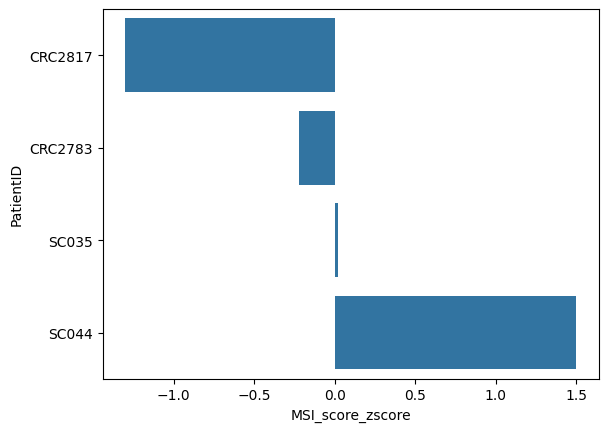

In [274]:
MSIintensityByPatient_Joanito = list()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_Joanito.append( [PatientID, np.mean(edf['MSI_score'])] )
MSIintensityByPatient_Joanito = pd.DataFrame(MSIintensityByPatient_Joanito, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_Joanito['MSI_score']), np.std(MSIintensityByPatient_Joanito['MSI_score'])
MSIintensityByPatient_Joanito['MSI_score_zscore'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_Joanito['MSI_score'] ]
sns.barplot(data=MSIintensityByPatient_Joanito.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore')

In [286]:
for tup in MSIintensityByPatient_Joanito.itertuples():
    if tup.MSI_score_zscore < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-L'
    elif tup.MSI_score_zscore > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-H'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-I'

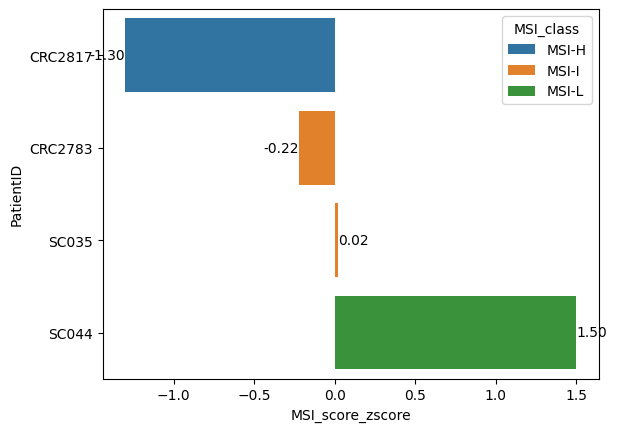

In [279]:
MSIintensityByPatient_Joanito['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_Joanito['PatientID'] ]
ax = sns.barplot(data=MSIintensityByPatient_Joanito.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore', hue='MSI_class')
ax.bar_label(fmt='%.2f', container=ax.containers[0]);
ax.bar_label(fmt='%.2f', container=ax.containers[1]);
ax.bar_label(fmt='%.2f', container=ax.containers[2]);

### Chen et al

In [280]:
MSIintensityByPatient_Chen = list()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_Chen.append( [PatientID, np.mean(edf['MSI_score'])] )
MSIintensityByPatient_Chen = pd.DataFrame(MSIintensityByPatient_Chen, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_Chen['MSI_score']), np.std(MSIintensityByPatient_Chen['MSI_score'])
MSIintensityByPatient_Chen['MSI_score_zscore'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_Chen['MSI_score'] ]
ax = sns.barplot(data=MSIintensityByPatient_Chen.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore')
ax.bar_label(fmt='%.2f', container=ax.containers[0]);

/tmp/ipykernel_164097/1204193153.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID'):


In [289]:
for tup in MSIintensityByPatient_Chen.itertuples():
    if tup.MSI_score_zscore < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-L'
    elif tup.MSI_score_zscore > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-H'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-I'

In [742]:
sns.color_palette('icefire_r', 10)

[(0.95020929, 0.5832232, 0.34508419),
 (0.86286243, 0.33312058, 0.20274969),
 (0.65988195, 0.18734638, 0.26543435),
 (0.38288348, 0.16254006, 0.2163249),
 (0.17797765, 0.11994436, 0.13058435),
 (0.13405762, 0.13188822, 0.16820842),
 (0.23018113, 0.22132414, 0.39945577),
 (0.27690355, 0.3607736, 0.73659374),
 (0.248686, 0.56358255, 0.80961366),
 (0.48183174, 0.73401449, 0.80839675)]

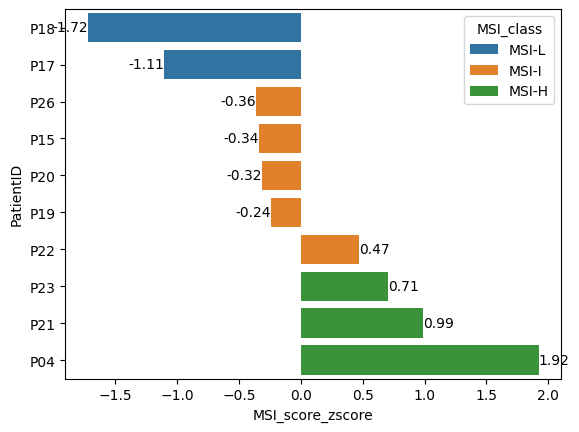

In [741]:
MSIintensityByPatient_Chen['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_Chen['PatientID'] ]
ax = sns.barplot(data=MSIintensityByPatient_Chen.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore', hue='MSI_class')
ax.bar_label(fmt='%.2f', container=ax.containers[0]);
ax.bar_label(fmt='%.2f', container=ax.containers[1]);
ax.bar_label(fmt='%.2f', container=ax.containers[2]);

In [291]:
dict_PatientID_to_MSI_class = dict(sorted(dict_PatientID_to_MSI_class.items(), key=lambda x:x[1]))
dict_PatientID_to_MSI_class

{'SC044': 'MSI-H',
 'P04': 'MSI-H',
 'P21': 'MSI-H',
 'P23': 'MSI-H',
 'CRC2783': 'MSI-I',
 'SC035': 'MSI-I',
 'P15': 'MSI-I',
 'P19': 'MSI-I',
 'P20': 'MSI-I',
 'P22': 'MSI-I',
 'P26': 'MSI-I',
 'CRC2817': 'MSI-L',
 'P17': 'MSI-L',
 'P18': 'MSI-L'}

## 1. Scanpy's rank_genes_groups (categorical)

### Joanito et al

In [1085]:
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]

In [1159]:
adata_epi_joanito_tumor_MSI_H = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-H'].copy()
adata_epi_joanito_tumor_MSI_L = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-L'].copy()

intersecting_genes = set(adata_epi_joanito_tumor_MSI_H.var.index).intersection(set(adata_epi_joanito_tumor_MSI_L.var.index))
print(adata_epi_joanito_tumor_MSI_H.var.shape[0], adata_epi_joanito_tumor_MSI_L.var.shape[0], len(intersecting_genes))
minimum_cell_percentage = 0.05
sc.pp.filter_genes(adata_epi_joanito_tumor_MSI_H, min_cells=int(adata_epi_joanito_tumor_MSI_H.obs.shape[0]*minimum_cell_percentage))
sc.pp.filter_genes(adata_epi_joanito_tumor_MSI_L, min_cells=int(adata_epi_joanito_tumor_MSI_H.obs.shape[0]*minimum_cell_percentage))
intersecting_genes = set(adata_epi_joanito_tumor_MSI_H.var.index).intersection(set(adata_epi_joanito_tumor_MSI_L.var.index))
print(adata_epi_joanito_tumor_MSI_H.var.shape[0], adata_epi_joanito_tumor_MSI_L.var.shape[0], len(intersecting_genes))

29388 29388 29388
12592 14160 11821


In [ ]:
sc.pp.normalize_total(adata_epi_joanito_tumor_MSI_H)
sc.pp.log1p(adata_epi_joanito_tumor_MSI_H)

sc.pp.normalize_total(adata_epi_joanito_tumor_MSI_L)
sc.pp.log1p(adata_epi_joanito_tumor_MSI_L)

In [1117]:
adata_epi_joanito_tumor_1 = adata_epi_joanito_tumor[(adata_epi_joanito_tumor.obs['MSI_class'].isin(['MSI-L', 'MSI-H']))].copy()
adata_epi_joanito_tumor_1.raw = adata_epi_joanito_tumor_1

sc.pp.normalize_total(adata_epi_joanito_tumor_1)
sc.pp.log1p(adata_epi_joanito_tumor_1)

# sc.pp.scale is not performed
# https://discourse.scverse.org/t/i-have-always-had-a-question-do-i-need-to-scale-my-adata-before-running-sc-tl-score-genes/2305/3 

In [1156]:
adata_epi_joanito_tumor_1.var

n_cells     mt   ribo     hb  n_cells_by_counts  mean_counts  \
AL627309.1      154  False  False  False                  4     0.001255   
AL627309.5      255  False  False  False                 19     0.007369   
AP006222.2      453  False  False  False                  7     0.003089   
LINC01409      4681  False  False  False                368     0.159485   
FAM87B           66  False  False  False                  1     0.000575   
...             ...    ...    ...    ...                ...          ...   
AC136616.2      804  False  False  False                  0     0.000000   
AC141272.1      879  False  False  False                  0     0.000000   
AC007325.1       23  False  False  False                  0     0.000000   
AC007325.4      142  False  False  False                 15     0.007655   
AC007325.2      936  False  False  False                420     0.212880   

            log1p_mean_counts  pct_dropout_by_counts  total_counts  \
AL627309.1           0.001255              99.764706      2.134112   
AL627309.5           0.007342              98.882353     12.527359   
AP006222.2           0.003084              99.588235      5.251209   
LINC01409            0.147976              78.352941    271.124481   
FAM87B               0.000574              99.941176      0.976915   
...                       ...                    ...           ...   
AC136616.2           0.000000             100.000000      0.000000   
AC141272.1           0.000000             100.000000      0.000000   
AC007325.1           0.000000             100.000000      0.000000   
AC007325.4           0.007625              99.117647     13.012843   
AC007325.2           0.192998              75.294118    361.896027   

            log1p_total_counts  
AL627309.1            1.142346  
AL627309.5            2.604714  
AP006222.2            1.832775  
LINC01409             5.606260  
FAM87B                0.681538  
...                        ...  
AC136616.2            0.000000  
AC141272.1            0.000000  
AC007325.1            0.000000  
AC007325.4            2.639974  
AC007325.2            5.894116  

[29388 rows x 10 columns]

In [1140]:
sc.tl.rank_genes_groups(adata_epi_joanito_tumor_1, groupby='MSI_class', method='wilcoxon', use_raw=False,)

In [1150]:
sns.scatterplot(x=pd.DataFrame(adata_epi_joanito_tumor_1.uns['rank_genes_groups']['logfoldchanges']).sample(1000, random_state=42)['MSI-L'], 
                y=pd.DataFrame(adata_epi_joanito_tumor_1.uns['rank_genes_groups']['logfoldchanges']).sample(1000, random_state=42)['MSI-L'])

<Axes: xlabel='MSI-L', ylabel='MSI-L'>

In [255]:
saveWithPickle(adata_epi_joanito_tumor_1.uns['rank_genes_groups'], '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification', 'dict.Joanito_tumor_cells_rank_genes_groups')

In [189]:
adata_epi_joanito_tumor_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/dict.Joanito_tumor_cells_rank_genes_groups.pickle')

In [ ]:
joanito_tumor_DEG_names = pd.DataFrame(adata_epi_joanito_tumor_1['names'])
joanito_tumor_DEG_score = pd.DataFrame(adata_epi_joanito_tumor_1['scores'])
joanito_tumor_DEG_lfc   = pd.DataFrame(adata_epi_joanito_tumor_1['logfoldchanges'])
joanito_tumor_DEG_p  = pd.DataFrame(adata_epi_joanito_tumor_1['pvals'])
joanito_tumor_DEG_adjp  = pd.DataFrame(adata_epi_joanito_tumor_1['pvals_adj'])

joanito_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI_H', 1 : 'MSI_L' }

for tup in joanito_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        joanito_tumor_DEG_summary.append( [elem, 
                                           list(joanito_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

joanito_tumor_DEG_summary = pd.DataFrame(joanito_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])

In [263]:
joanito_tumor_DEG_summary.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t', index=False)

In [194]:
joanito_tumor_DEG_summary = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')

### Chen et al

In [265]:
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

In [266]:
adata_epi_chen_tumor_1 = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['MSI_class'].isin(['MSI-L', 'MSI-H']))].copy()
adata_epi_chen_tumor_1.raw = adata_epi_chen_tumor_1
sc.pp.normalize_total(adata_epi_chen_tumor_1)
sc.pp.log1p(adata_epi_chen_tumor_1)

adata_epi_chen_tumor_1.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in adata_epi_chen_tumor_1.obs['PatientID'] ]

In [267]:
sc.tl.rank_genes_groups(adata_epi_chen_tumor_1, groupby='MSI_class', method='wilcoxon')

In [268]:
saveWithPickle(adata_epi_chen_tumor_1.uns['rank_genes_groups'], '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification', 'dict.Chen_tumor_cells_rank_genes_groups')

In [269]:
chen_tumor_DEG_names = pd.DataFrame(adata_epi_chen_tumor_1.uns['rank_genes_groups']['names'])
chen_tumor_DEG_score = pd.DataFrame(adata_epi_chen_tumor_1.uns['rank_genes_groups']['scores'])
chen_tumor_DEG_lfc   = pd.DataFrame(adata_epi_chen_tumor_1.uns['rank_genes_groups']['logfoldchanges'])
chen_tumor_DEG_p  = pd.DataFrame(adata_epi_chen_tumor_1.uns['rank_genes_groups']['pvals'])
chen_tumor_DEG_adjp  = pd.DataFrame(adata_epi_chen_tumor_1.uns['rank_genes_groups']['pvals_adj'])

In [270]:
chen_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI_H', 1 : 'MSI_L' }

for tup in chen_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        chen_tumor_DEG_summary.append( [elem, 
                                           list(chen_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

chen_tumor_DEG_summary = pd.DataFrame(chen_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])

In [271]:
chen_tumor_DEG_summary.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t', index=False)

In [195]:
chen_tumor_DEG_summary = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')

### Compare results between the two datasets

In [1054]:
joanito_tumor_DEG_summary   = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')

In [1057]:
chen_tumor_DEG_summary['adjusted_pvalue'].replace(0, min(chen_tumor_DEG_summary[chen_tumor_DEG_summary['adjusted_pvalue']!=0]['adjusted_pvalue']), inplace=True)
chen_tumor_DEG_summary['adjusted_pvalue'].replace(0, min(chen_tumor_DEG_summary[chen_tumor_DEG_summary['adjusted_pvalue']!=0]['adjusted_pvalue']), inplace=True)

In [1058]:
min(joanito_tumor_DEG_summary['adjusted_pvalue']), min(chen_tumor_DEG_summary['adjusted_pvalue'])

(1.1898030162781975e-185, 3.1953774328038164e-297)

In [1059]:
joanito_tumor_DEG_summary['log10adjpval']   = [ -np.log(adjp) for adjp in joanito_tumor_DEG_summary['adjusted_pvalue'] ]
chen_tumor_DEG_summary['log10adjpval']      = [ -np.log(adjp) for adjp in chen_tumor_DEG_summary['adjusted_pvalue'] ]

In [1060]:
# # Strict
# joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['log10adjpval']>=10) & (joanito_tumor_DEG_summary['MSI_class']=='MSI_H')].copy()
# chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['log10adjpval']>=10) & (chen_tumor_DEG_summary['MSI_class']=='MSI_H')].copy()

# Broad
joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01) & (joanito_tumor_DEG_summary['MSI_class']=='MSI_H')].copy()
chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['adjusted_pvalue']<=0.01) & (chen_tumor_DEG_summary['MSI_class']=='MSI_H')].copy()

In [1061]:
joanito_down = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']<=-2) ]
joanito_up = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']>=2) ]

chen_down = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']<=-2) ]
chen_up = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']>=2) ]

In [1062]:
print(f'Joanito up: {len(joanito_up)}\tJoanito down: {len(joanito_down)}')
print(f'Chen up: {len(chen_up)}\tChen down: {len(chen_down)}')

Joanito up: 1332	Joanito down: 653
Chen up: 284	Chen down: 262


In [1063]:
intersecting_up = set(joanito_up['gene']).intersection(set(chen_up['gene']))
intersecting_down = set(joanito_down['gene']).intersection(set(chen_down['gene']))

print(len(intersecting_up), len(intersecting_down))

68 56


In [1064]:
joanito_tumor_DEG_summary.head(1)

gene      score  logfoldchanges         pvalue  adjusted_pvalue  \
0  MARCKSL1  29.091002        3.570664  4.665734e-186    2.285277e-182   

  MSI_class  log10adjpval  
0     MSI_H       418.244

In [1065]:
chen_tumor_DEG_summary.head(1)

gene     score  logfoldchanges  pvalue  adjusted_pvalue MSI_class  \
0  REG1A  49.19643        6.870084     0.0    3.195377e-297     MSI_H   

   log10adjpval  
0    682.706067

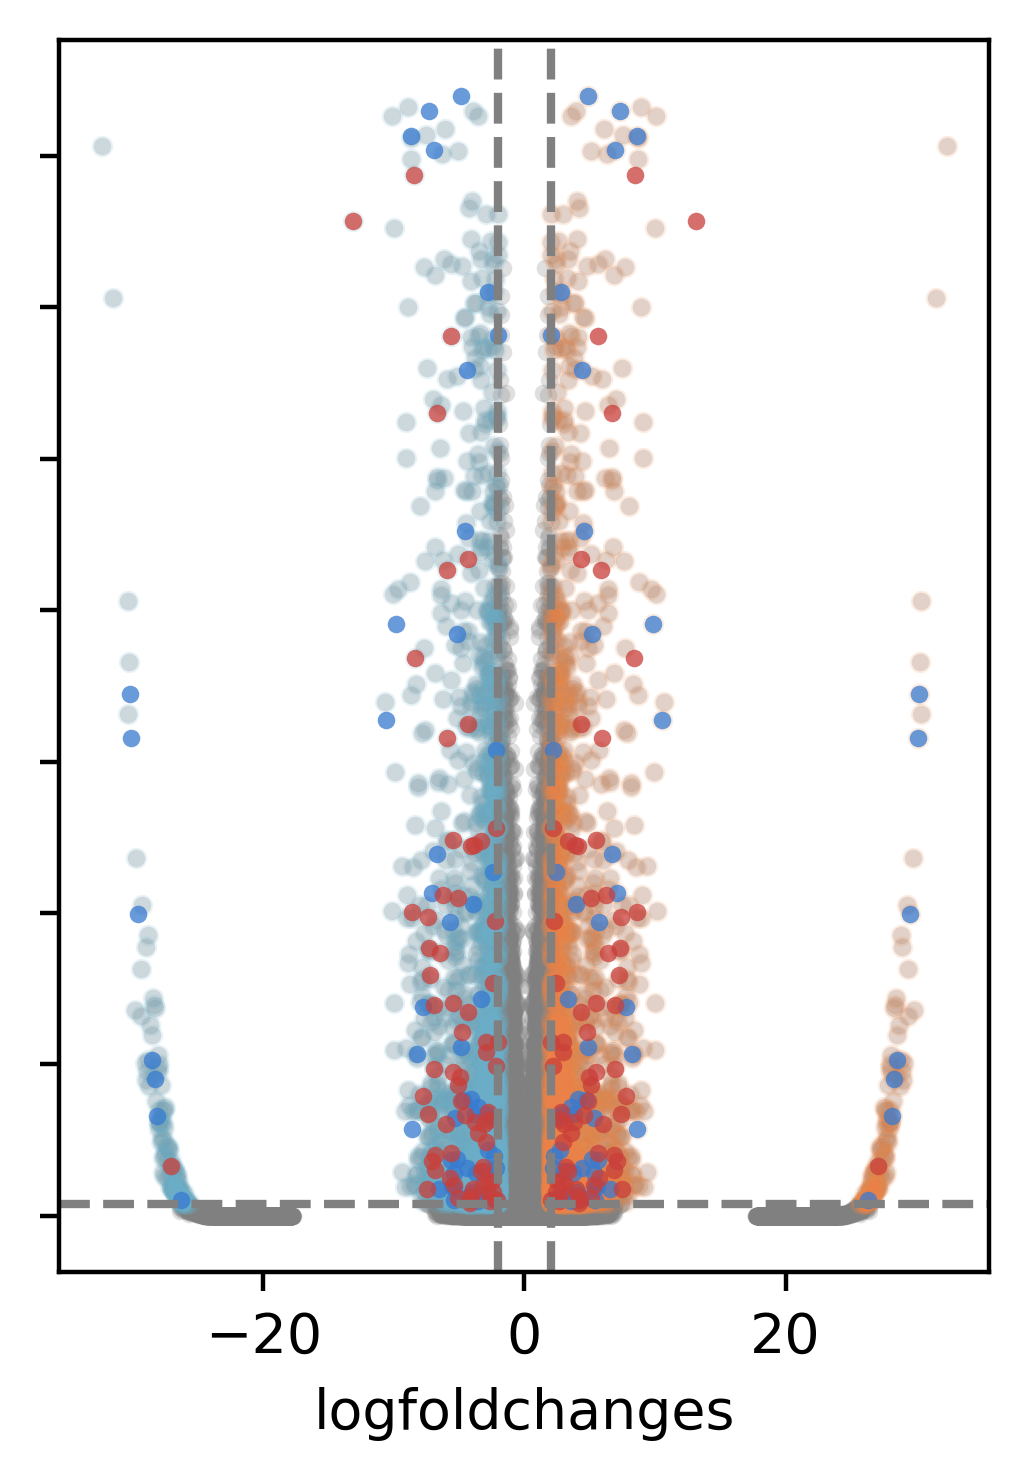

In [1068]:
plt.figure(figsize=(3, 4), dpi=400)

up      = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
down    = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]

up2     = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']>=2) & (joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']<=-2)&(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
down2   = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

# ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
# plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-8.5, 8.5]);

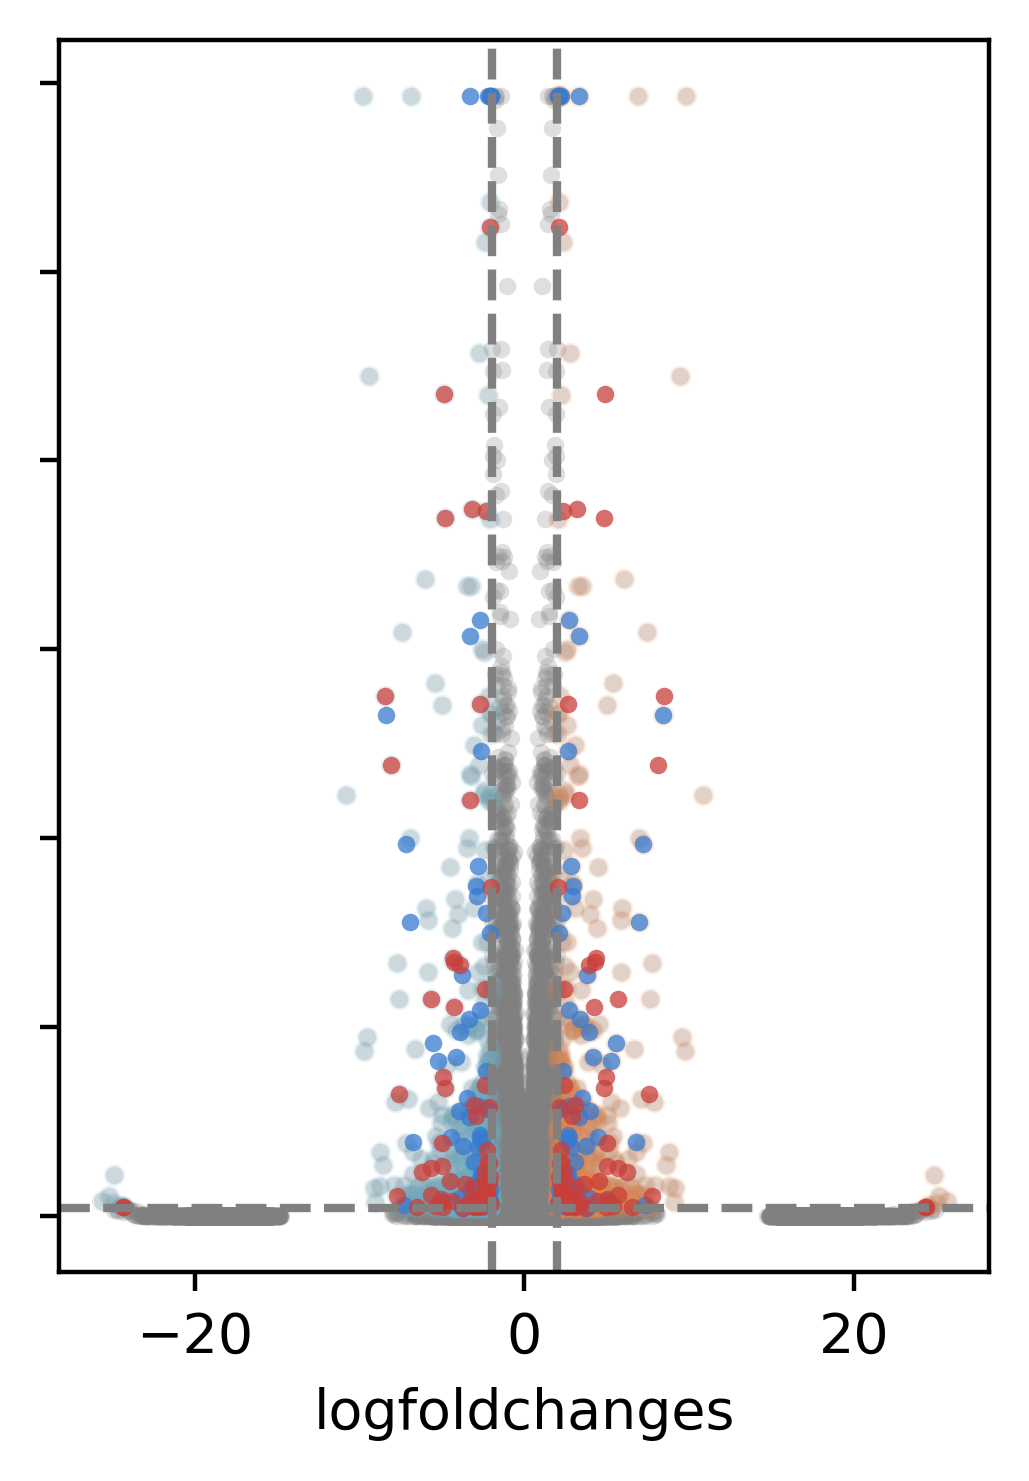

In [1125]:
plt.figure(figsize=(3, 4), dpi=400)

up      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_up)]
down    = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_down)]

up2     = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']>=2) & (chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']<=-2)&(chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
down2   = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

# ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
# plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-8.5, 8.5]);

In [1031]:
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

In [357]:
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor.copy()
adata_epi_chen_tumor_copy = adata_epi_chen_tumor.copy()

sc.pp.normalize_total(adata_epi_joanito_tumor_copy)
sc.pp.log1p(adata_epi_joanito_tumor_copy)
adata_epi_joanito_tumor_copy.raw = adata_epi_joanito_tumor_copy

sc.pp.normalize_total(adata_epi_chen_tumor_copy)
sc.pp.log1p(adata_epi_chen_tumor_copy)
adata_epi_chen_tumor_copy.raw = adata_epi_chen_tumor_copy

In [364]:
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_down), score_name='DW')

sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_down), score_name='DW')

In [370]:
sns.color_palette('viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

<Axes: xlabel='MSI_class', ylabel='DW'>

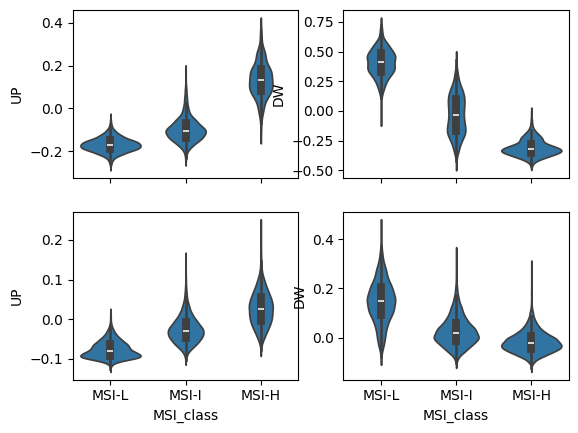

In [384]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)
sns.violinplot(data=adata_epi_joanito_tumor_copy.obs, x='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], y='UP', ax=axes[0, 0])
sns.violinplot(data=adata_epi_joanito_tumor_copy.obs, x='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], y='DW', ax=axes[0, 1])
sns.violinplot(data=adata_epi_chen_tumor_copy.obs, x='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], y='UP', ax=axes[1, 0])
sns.violinplot(data=adata_epi_chen_tumor_copy.obs, x='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], y='DW', ax=axes[1, 1])

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


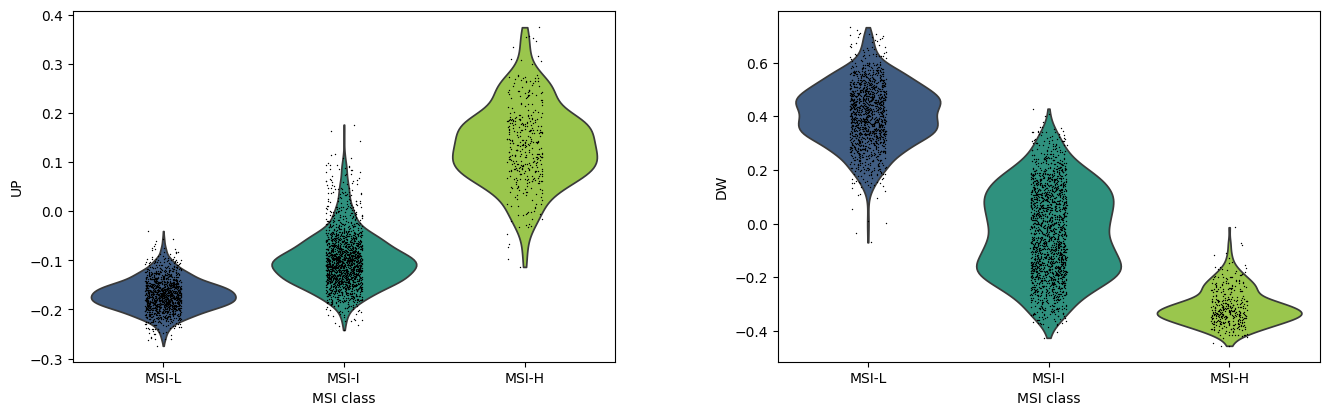

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


In [376]:
sc.pl.violin(adata_epi_joanito_tumor_copy, keys=['UP', 'DW'],
             groupby='MSI_class', 
             order=['MSI-L', 'MSI-I', 'MSI-H'], 
             palette={ 'MSI-L' : sns.color_palette('viridis')[1], 'MSI-I' : sns.color_palette('viridis')[3], 'MSI-H' : sns.color_palette('viridis')[5] })
sc.pl.violin(adata_epi_chen_tumor_copy, keys=['UP', 'DW'], groupby='MSI_class', order=['MSI-L', 'MSI-I', 'MSI-H'], 
             palette={ 'MSI-L' : sns.color_palette('viridis')[1], 'MSI-I' : sns.color_palette('viridis')[3], 'MSI-H' : sns.color_palette('viridis')[5] })

In [423]:
ax = sns.scatterplot(data=chen_down.sort_values('logfoldchanges'), x='gene', y='logfoldchanges')
ax.set_xticklabels([]);
ax.set_xticks([]);

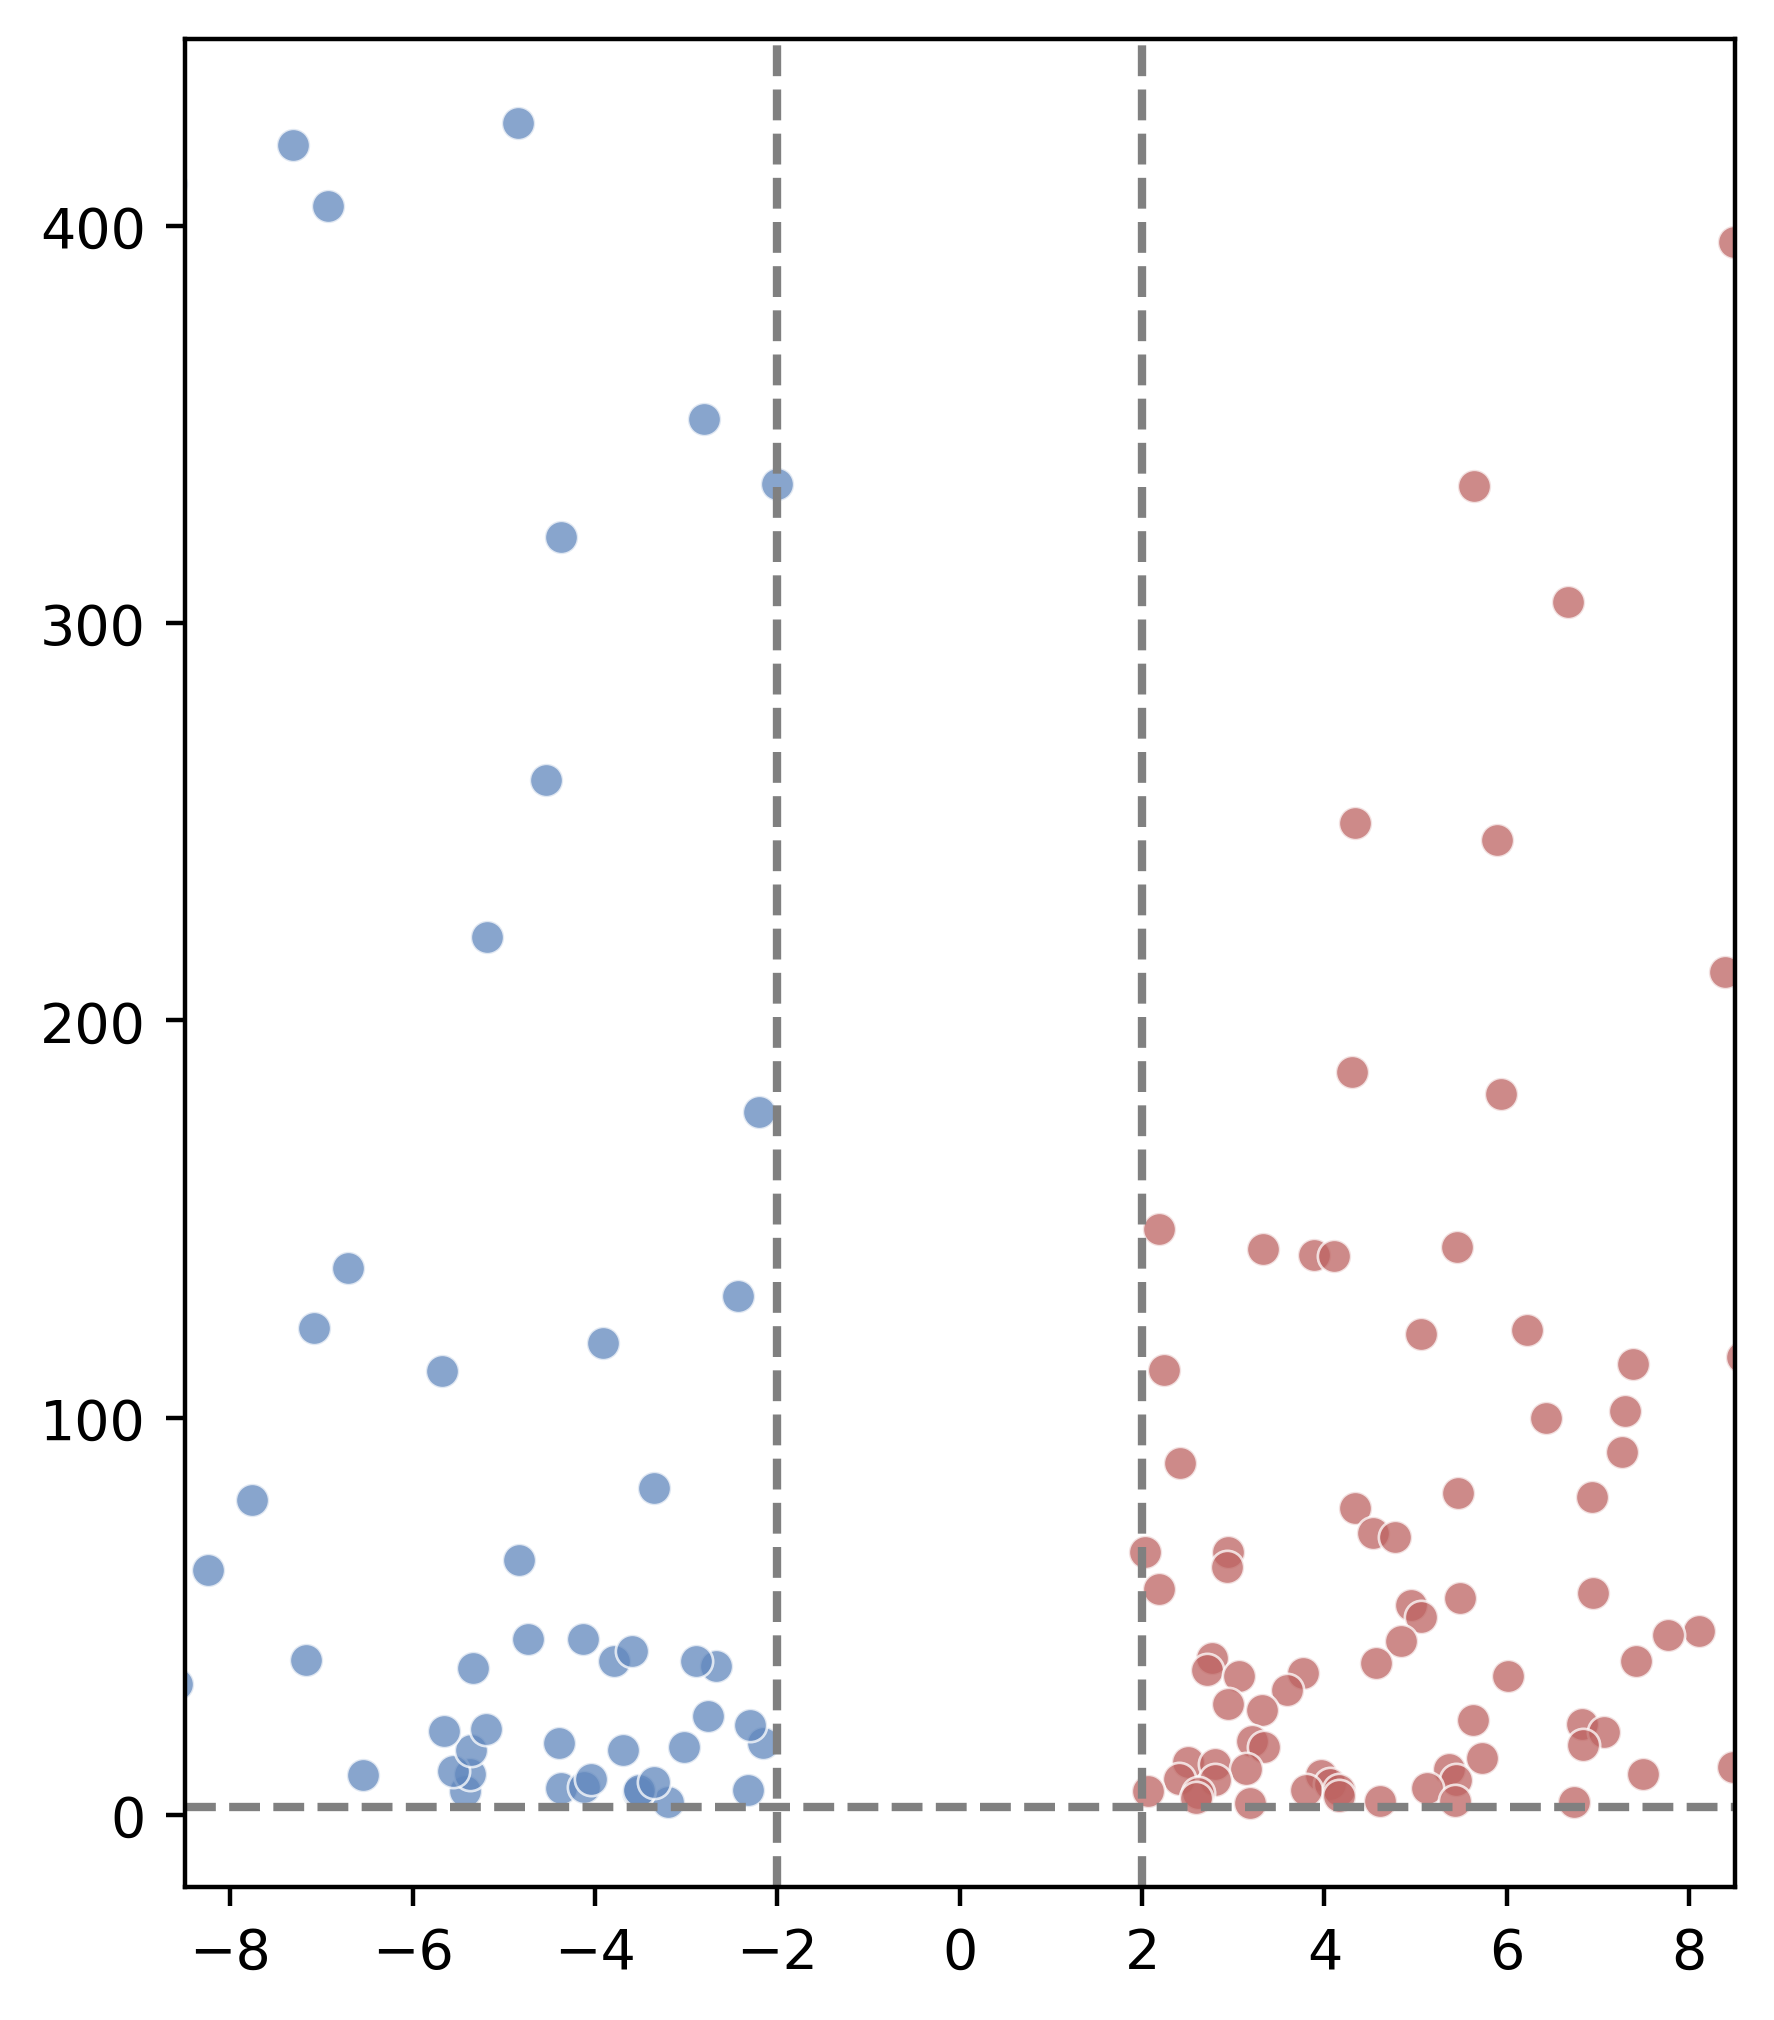

In [411]:
plt.figure(figsize=(5, 6), dpi=400)

joanito_tumor_DEG_summary_sig_oi = joanito_tumor_DEG_summary_sig[joanito_tumor_DEG_summary_sig['gene'].isin(list(intersecting_up.union(intersecting_down)))]

down = joanito_tumor_DEG_summary_sig_oi[(joanito_tumor_DEG_summary_sig_oi['logfoldchanges']<=-2) ]
up = joanito_tumor_DEG_summary_sig_oi[(joanito_tumor_DEG_summary_sig_oi['logfoldchanges']>=2) ]

nonSigGenes = [ gene for gene in joanito_tumor_DEG_summary_sig_oi['gene'] if gene not in set(down['gene']).union(set(up['gene'])) ]
sns.scatterplot(x=joanito_tumor_DEG_summary_sig_oi[(joanito_tumor_DEG_summary_sig_oi['gene'].isin(nonSigGenes))]['logfoldchanges'], 
                y=joanito_tumor_DEG_summary_sig_oi[(joanito_tumor_DEG_summary_sig_oi['gene'].isin(nonSigGenes))]['log10adjpval'],
                s=10, 
                alpha=0.1, 
                color='gray',
                )

sns.scatterplot(x=down['logfoldchanges'],y=down['log10adjpval'], 
                # s=5, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=.75,)
sns.scatterplot(x=up['logfoldchanges'],y=up['log10adjpval'], 
                # s=5,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=.75,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

In [268]:
plt.figure(figsize=(6, 8), dpi=400)


nonSigGenes = [ gene for gene in joanito_tumor_DEG_summary_sig['gene'] if gene not in set(down['gene']).union(set(up['gene'])) ]
sns.scatterplot(x=joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['gene'].isin(nonSigGenes))]['logfoldchanges'], 
                y=joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['gene'].isin(nonSigGenes))]['log10adjpval'],
                s=10, 
                alpha=0.1, 
                color='gray',
                )

sns.scatterplot(x=down['logfoldchanges'],y=down['log10adjpval'], 
                # s=5, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=.75,)
sns.scatterplot(x=up['logfoldchanges'],y=up['log10adjpval'], 
                # s=5,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=.75,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

### pyDeseq2

In [440]:
joanito_tumor_DEG_summary   = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')

joanito_tumor_DEG_summary.columns   = ['gene'] + list(joanito_tumor_DEG_summary.columns)[1:]
chen_tumor_DEG_summary.columns      = ['gene'] + list(chen_tumor_DEG_summary.columns)[1:]

In [446]:
min(joanito_tumor_DEG_summary['padj']), min(chen_tumor_DEG_summary['padj'])

(7.518015201716195e-170, 4.876253341987117e-22)

In [447]:
joanito_tumor_DEG_summary['log10adjpval']   = [ -np.log(adjp) for adjp in joanito_tumor_DEG_summary['padj'] ]
chen_tumor_DEG_summary['log10adjpval']      = [ -np.log(adjp) for adjp in chen_tumor_DEG_summary['padj'] ]

In [450]:
# Broad
joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['padj']<=0.05)].copy()
chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['padj']<=0.05)].copy()

In [452]:
joanito_down = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['log2FoldChange']<=-2) ]
joanito_up = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['log2FoldChange']>=2) ]

chen_down = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['log2FoldChange']<=-2) ]
chen_up = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['log2FoldChange']>=2) ]

In [453]:
intersecting_up = set(joanito_up['gene']).intersection(set(chen_up['gene']))
intersecting_down = set(joanito_down['gene']).intersection(set(chen_down['gene']))

print(len(intersecting_up), len(intersecting_down))

36 23


In [ ]:
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

In [454]:
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor.copy()
adata_epi_chen_tumor_copy = adata_epi_chen_tumor.copy()

sc.pp.normalize_total(adata_epi_joanito_tumor_copy)
sc.pp.log1p(adata_epi_joanito_tumor_copy)
adata_epi_joanito_tumor_copy.raw = adata_epi_joanito_tumor_copy

sc.pp.normalize_total(adata_epi_chen_tumor_copy)
sc.pp.log1p(adata_epi_chen_tumor_copy)
adata_epi_chen_tumor_copy.raw = adata_epi_chen_tumor_copy

In [455]:
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_down), score_name='DW')

sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_down), score_name='DW')

## pyDESeq2 & DecoupleR: Pseudo-bulk differential expression analysis

### Joanito et al

In [992]:
adata_epi_joanito_tumor_2 = adata_epi_joanito_tumor[(adata_epi_joanito_tumor.obs['MSI_class'].isin(['MSI-L', 'MSI-H']))].copy()
adata_epi_joanito_tumor_2.raw = adata_epi_joanito_tumor_2

adata_epi_joanito_tumor_2.layers['counts'] = adata_epi_joanito_tumor_2.X
# sc.pp.normalize_total(adata_epi_joanito_tumor_2, target_sum=1e4)
# sc.pp.log1p(adata_epi_joanito_tumor_2)
# adata_epi_joanito_tumor_2.layers['normalized'] = adata_epi_joanito_tumor_2.X

In [426]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_epi_joanito_tumor_2,
    sample_col='SampleID',
    groups_col='MSI_class',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

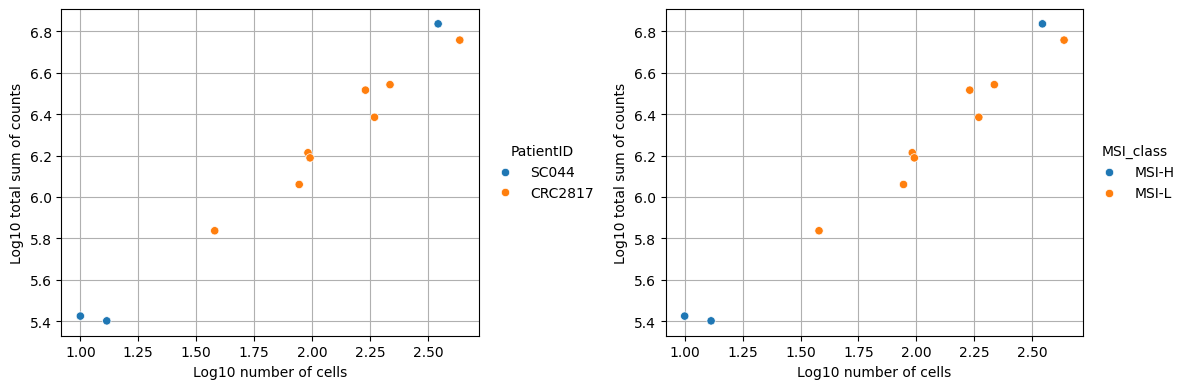

In [427]:
dc.plot_psbulk_samples(pdata, groupby=['PatientID', 'MSI_class'], figsize=(12, 4))

In [428]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)

pdata.X[0][np.isnan(pdata.X[0])] = 0 
pdata.X[1][np.isnan(pdata.X[1])] = 0 

sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

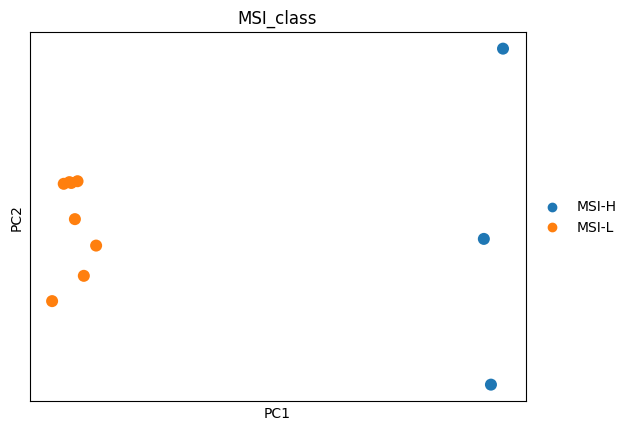

In [429]:
sc.pl.pca(pdata, color=['MSI_class'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

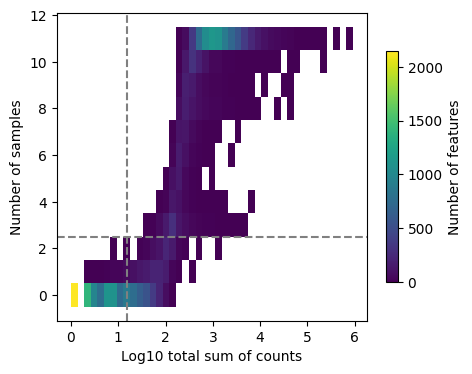

In [487]:
dc.plot_filter_by_expr(pdata, group='MSI_class', min_count=10, min_total_count=15)

In [430]:
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [582]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='MSI_class',
    ref_level=['MSI_H', 'MSI_L'],
    refit_cooks=True,
    inference=inference,
)

/tmp/ipykernel_235196/96934330.py:3: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/tmp/ipykernel_235196/96934330.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [ ]:
dds.deseq2()

In [491]:
stat_res = DeseqStats(
    dds,
    contrast=['MSI_class', 'MSI-H', 'MSI-L'],
    inference=inference,
)

In [492]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: MSI_class MSI-H vs MSI-L
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.666385        1.506899  2.020696  0.745733  0.455829       NaN
A1CF       33.873634       -1.636261  0.382939 -4.272897  0.000019  0.000119
A2M         0.376737        0.325717  2.479318  0.131374  0.895480       NaN
A2M-AS1     0.171725        1.340267  3.356088  0.399354  0.689633       NaN
A2ML1-AS1   1.049051        3.036381  1.941607  1.563849  0.117853  0.217315
...              ...             ...       ...       ...       ...       ...
ZXDC       43.320051       -0.659749  0.279664 -2.359073  0.018321  0.047330
ZYG11A      0.031871        2.099004  3.848597  0.545395  0.585482       NaN
ZYG11B     24.337501        0.287764  0.361766  0.795440  0.426357  0.564997
ZYX        81.474044        0.694955  0.214791  3.235499  0.001214  0.004643
ZZEF1      54.136660       -1.147490  0.357234 -3.212154  0.001317  0.004979

[25083 rows 

... done in 1.16 seconds.



In [493]:
results_df = stat_res.results_df
results_df.dropna(inplace=True)
results_df.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t',)

In [135]:
results_df = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
results_df[results_df['Unnamed: 0'].isin(['S100A6', 'S100A10', 'S100A11'])]

Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
11929    S100A10  10843.398911       -2.712826  0.149644 -18.128586   
11930    S100A11   7709.087350       -2.335535  0.171343 -13.630765   
11938     S100A6  57615.710272       -4.059840  0.349173 -11.627026   

             pvalue          padj  
11929  1.895698e-73  2.296857e-70  
11930  2.628112e-42  7.016167e-40  
11938  3.003816e-31  3.846594e-29

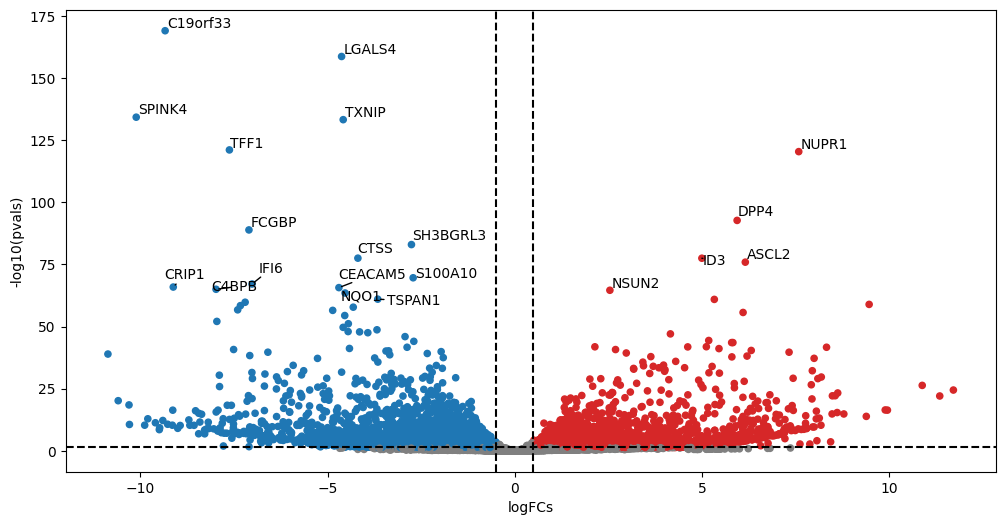

In [494]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(12, 6)
)

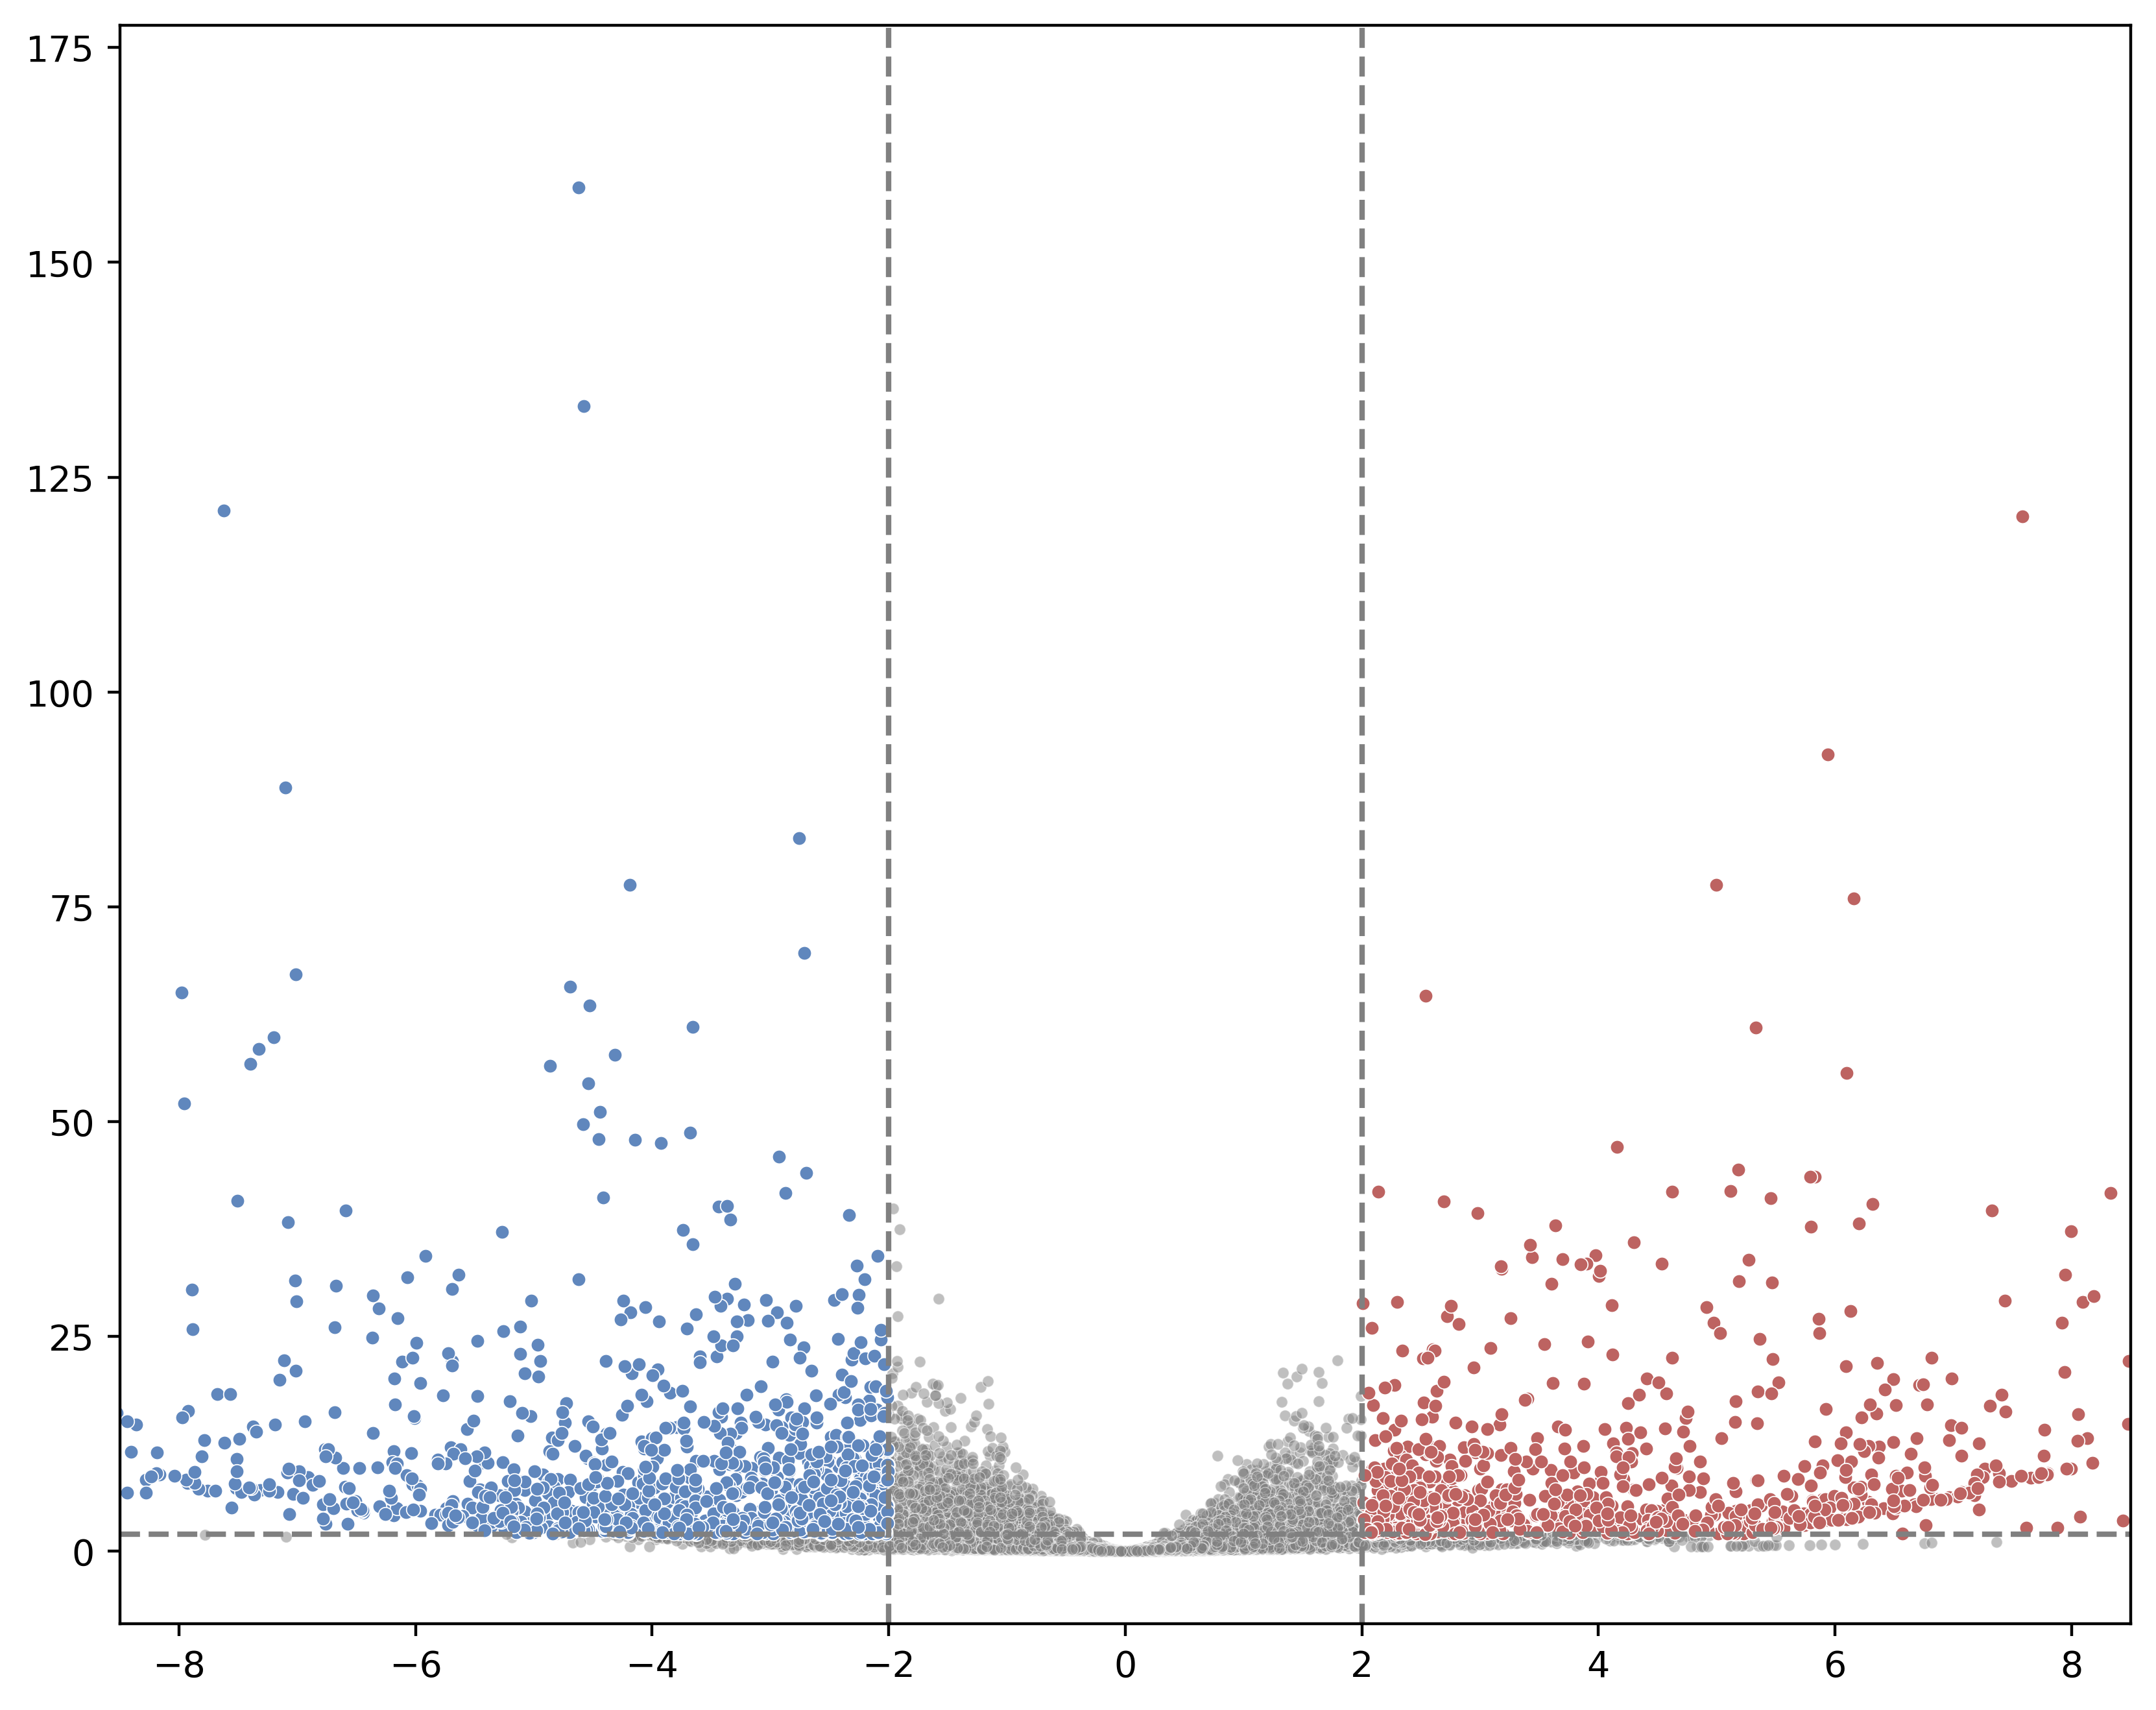

In [495]:
# Chen_DEGs_oi = Chen_DEGs[(Chen_DEGs['MSI_class']=='High') & (Chen_DEGs['gene'].isin(Joanito_DEGs_oi['gene']))].copy()

plt.figure(figsize=(10, 8), dpi=400)
sns.scatterplot(x=results_df['log2FoldChange'], 
                y=results_df['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.5, 
                color='gray',
                )

down = results_df[(results_df['log2FoldChange']<=-2)&(results_df['padj']<=0.01)]
up = results_df[(results_df['log2FoldChange']>=2)&(results_df['padj']<=0.01)]
    
sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=1,)
sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=1,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

### Chen et al

In [1002]:
adata_epi_chen_tumor_2 = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['MSI_class'].isin(['MSI-L', 'MSI-H']))].copy()
adata_epi_chen_tumor_2.raw = adata_epi_chen_tumor_2

adata_epi_chen_tumor_2.layers['counts'] = adata_epi_chen_tumor_2.X

In [650]:
adata_epi_chen_tumor_2.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'Accession', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2',
       'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response',
       'Manual_CellType_lvl_1', 'MSI_score', 'MSI_score_z', 'TumorStage',
       'TumorRegressionRatio', 'Age', 'MSI_class'],
      dtype='object')

In [1003]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_epi_chen_tumor_2,
    sample_col='SampleID',
    groups_col='MSI_class',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

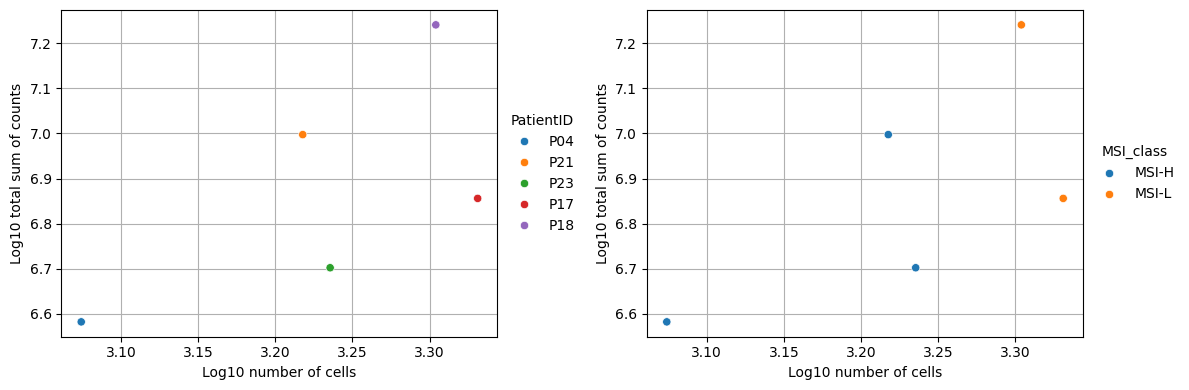

In [1004]:
dc.plot_psbulk_samples(pdata, groupby=['PatientID', 'MSI_class'], figsize=(12, 4))

In [656]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)

pdata.X[0][np.isnan(pdata.X[0])] = 0 
pdata.X[1][np.isnan(pdata.X[1])] = 0 

sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [1015]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=36)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='MSI_class',
    ref_level=['MSI_H', 'MSI_L'],
    refit_cooks=True,
    inference=inference,
)

/tmp/ipykernel_164097/3966709738.py:3: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/tmp/ipykernel_164097/3966709738.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [1016]:
dds.deseq2()

Using mean fit type.
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 1.35 seconds.

Fitting dispersion trend curve...
... done in 0.00 seconds.

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.54 seconds.

Fitting LFCs...
... done in 1.44 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [1017]:
stat_res = DeseqStats(
    dds,
    contrast=['MSI_class', 'MSI-H', 'MSI-L'],
    inference=inference,
)

In [1018]:
stat_res.summary()

results_df = stat_res.results_df
results_df.dropna(inplace=True)

Running Wald tests...


Log2 fold change & Wald test p-value: MSI_class MSI-H vs MSI-L
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        5.180332       -1.136217  0.998410 -1.138026  0.255110      NaN
A1BG-AS1    2.157019        3.196129  2.067415  1.545955  0.122116      NaN
A1CF      104.112975       -2.539986  1.438553 -1.765654  0.077454  0.99995
A2M        10.263850        0.719589  0.968602  0.742915  0.457533  0.99995
A2M-AS1     5.053189        0.134330  0.913280  0.147086  0.883064      NaN
...              ...             ...       ...       ...       ...      ...
ZXDC      339.678654       -0.393076  0.528489 -0.743774  0.457013  0.99995
ZYG11A     46.092757        1.144369  2.100682  0.544760  0.585918  0.99995
ZYG11B    158.524135       -0.143176  0.673992 -0.212430  0.831771  0.99995
ZYX       580.076290       -0.267153  0.758318 -0.352297  0.724616  0.99995
ZZEF1     498.479636        0.024875  0.729461  0.034101  0.972797  0.99995

[27956 rows x 6 columns]

... done in 1.42 seconds.



In [1019]:
results_df[(results_df.index.isin(['S100A2', 'S100A6', 'S100A10', 'S100A11']))]

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
S100A10  15373.552339       -1.612700  1.098142 -1.468572  0.141949  0.999950
S100A11   4543.800828       -1.243186  0.864735 -1.437649  0.150534  0.999950
S100A2     210.758584       -3.908410  0.918743 -4.254086  0.000021  0.010570
S100A6   46725.589285       -1.959056  0.627898 -3.120022  0.001808  0.178049

In [ ]:
results_df.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t',)

In [504]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(12, 6)
)

In [505]:
# Chen_DEGs_oi = Chen_DEGs[(Chen_DEGs['MSI_class']=='High') & (Chen_DEGs['gene'].isin(Joanito_DEGs_oi['gene']))].copy()

plt.figure(figsize=(10, 8), dpi=400)
sns.scatterplot(x=results_df['log2FoldChange'], 
                y=results_df['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.5, 
                color='gray',
                )

down = results_df[(results_df['log2FoldChange']<=-2)&(results_df['padj']<=0.01)]
up = results_df[(results_df['log2FoldChange']>=2)&(results_df['padj']<=0.01)]
    
sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=1,)
sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=1,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

In [506]:
for tup in results_df.itertuples():
    gene = tup.Index 
    if 'S100' in gene:
        print(f'{gene}\t{round(tup.log2FoldChange, 3)}')

S100A1	0.858
S100A10	-1.613
S100A11	-1.243
S100A13	-1.309
S100A14	-2.048
S100A16	-1.301
S100A2	-3.909
S100A3	-4.749
S100A4	-2.775
S100A5	-2.388
S100A6	-1.959
S100A8	-1.692
S100A9	-1.037
S100P	-1.913
S100PBP	0.101
S100Z	1.264


### Visuzlize results

In [933]:
joanito_tumor_DEG_summary   = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')

joanito_tumor_DEG_summary.columns   = ['gene'] + list(joanito_tumor_DEG_summary.columns)[1:]
chen_tumor_DEG_summary.columns      = ['gene'] + list(chen_tumor_DEG_summary.columns)[1:]

In [459]:
min(joanito_tumor_DEG_summary['padj']), min(chen_tumor_DEG_summary['padj'])

(7.518015201716195e-170, 4.876253341987117e-22)

In [934]:
joanito_tumor_DEG_summary['log10adjpval']   = [ -np.log10(adjp) for adjp in joanito_tumor_DEG_summary['padj'] ]
chen_tumor_DEG_summary['log10adjpval']      = [ -np.log10(adjp) for adjp in chen_tumor_DEG_summary['padj'] ]

In [935]:
# Broad
joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['padj']<=0.05)].copy()
chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['padj']<=0.05)].copy()

In [936]:
lfc_threshold = 1
joanito_down = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['log2FoldChange']<=-lfc_threshold) ]
joanito_up = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['log2FoldChange']>=lfc_threshold) ]

chen_down = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['log2FoldChange']<=-lfc_threshold) ]
chen_up = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['log2FoldChange']>=lfc_threshold) ]

In [937]:
len(set(joanito_down['gene'])), len(set(chen_down['gene']))

(2395, 66)

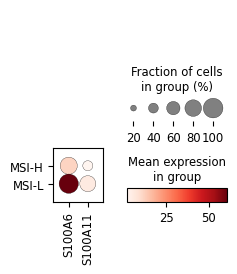

In [946]:
sc.pl.dotplot(adata_epi_chen_tumor[~adata_epi_chen_tumor.obs['MSI_class'].isin(['MSI-I'])], var_names=['S100A6', 'S100A11'], groupby='MSI_class')

In [953]:
for MSI_class, edf in adata_epi_chen_tumor.obs.groupby('MSI_class'):
    print(MSI_class, len(edf))

MSI-H 4565
MSI-I 4986
MSI-L 4158


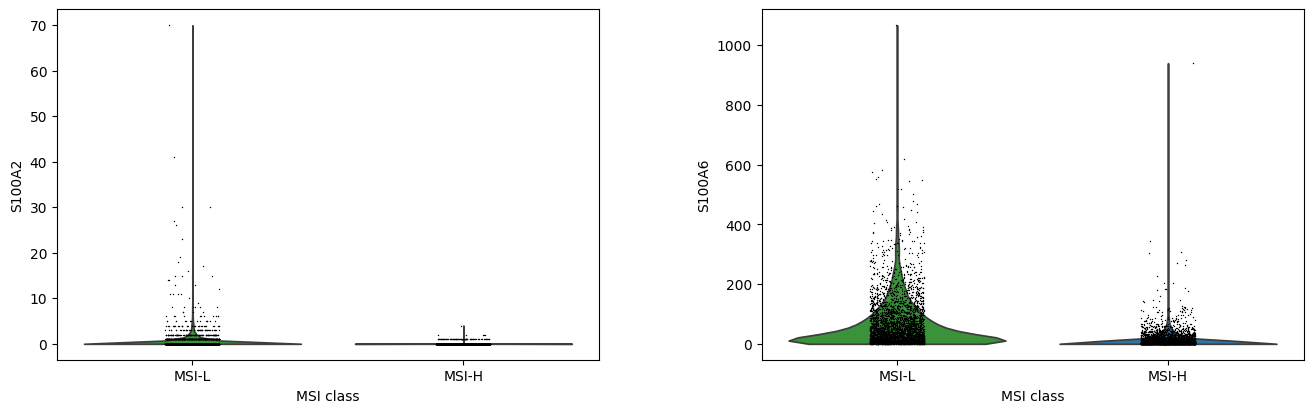

In [967]:
sc.pl.violin(adata_epi_chen_tumor, keys=['S100A2', 'S100A6'], groupby='MSI_class', order=['MSI-L', 'MSI-H'])

In [977]:
sc.pl.violin(pdata, keys=['S100A6'], groupby='MSI_class')

In [966]:
chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(['S100A2'])]

gene    baseMean  log2FoldChange     lfcSE     stat    pvalue  \
12602  S100A2  210.758584       -3.908577  0.823148 -4.74833  0.000002   

           padj  log10adjpval  
12602  0.000808       3.09274

In [460]:
intersecting_up = set(joanito_up['gene']).intersection(set(chen_up['gene']))
intersecting_down = set(joanito_down['gene']).intersection(set(chen_down['gene']))

print(len(intersecting_up), len(intersecting_down))

36 23


In [ ]:
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

In [ ]:
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor.copy()
adata_epi_chen_tumor_copy = adata_epi_chen_tumor.copy()

sc.pp.normalize_total(adata_epi_joanito_tumor_copy)
sc.pp.log1p(adata_epi_joanito_tumor_copy)
adata_epi_joanito_tumor_copy.raw = adata_epi_joanito_tumor_copy

sc.pp.normalize_total(adata_epi_chen_tumor_copy)
sc.pp.log1p(adata_epi_chen_tumor_copy)
adata_epi_chen_tumor_copy.raw = adata_epi_chen_tumor_copy

In [461]:
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, list(intersecting_down), score_name='DW')

sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_up), score_name='UP')
sc.tl.score_genes(adata_epi_chen_tumor_copy, list(intersecting_down), score_name='DW')

In [705]:
plt.figure(figsize=(3, 4), dpi=400)


up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]

up2 = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['log2FoldChange']>=2) & (joanito_tumor_DEG_summary['padj']<=0.01)]
up2 = up2[~up2['gene'].isin(up['gene'])]
down2 = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['log2FoldChange']<=-2)&(joanito_tumor_DEG_summary['padj']<=0.01)]
down2 = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['log2FoldChange'], 
                y=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['log2FoldChange'],y=down2['padj'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['log2FoldChange'],y=up2['padj'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-8.5, 8.5]);

In [700]:
sns.color_palette('vlag', 10)

[(0.34125337, 0.50923419, 0.73874905),
 (0.49566225, 0.60454154, 0.76238852),
 (0.64061445, 0.70437326, 0.80497621),
 (0.79159841, 0.81658489, 0.86776906),
 (0.93827772, 0.9322888, 0.94432312),
 (0.96784372, 0.91616744, 0.91126063),
 (0.90235365, 0.77267117, 0.76467793),
 (0.84190106, 0.62760645, 0.61740899),
 (0.7862306, 0.49245398, 0.48267247),
 (0.72743485, 0.35773314, 0.35378465)]

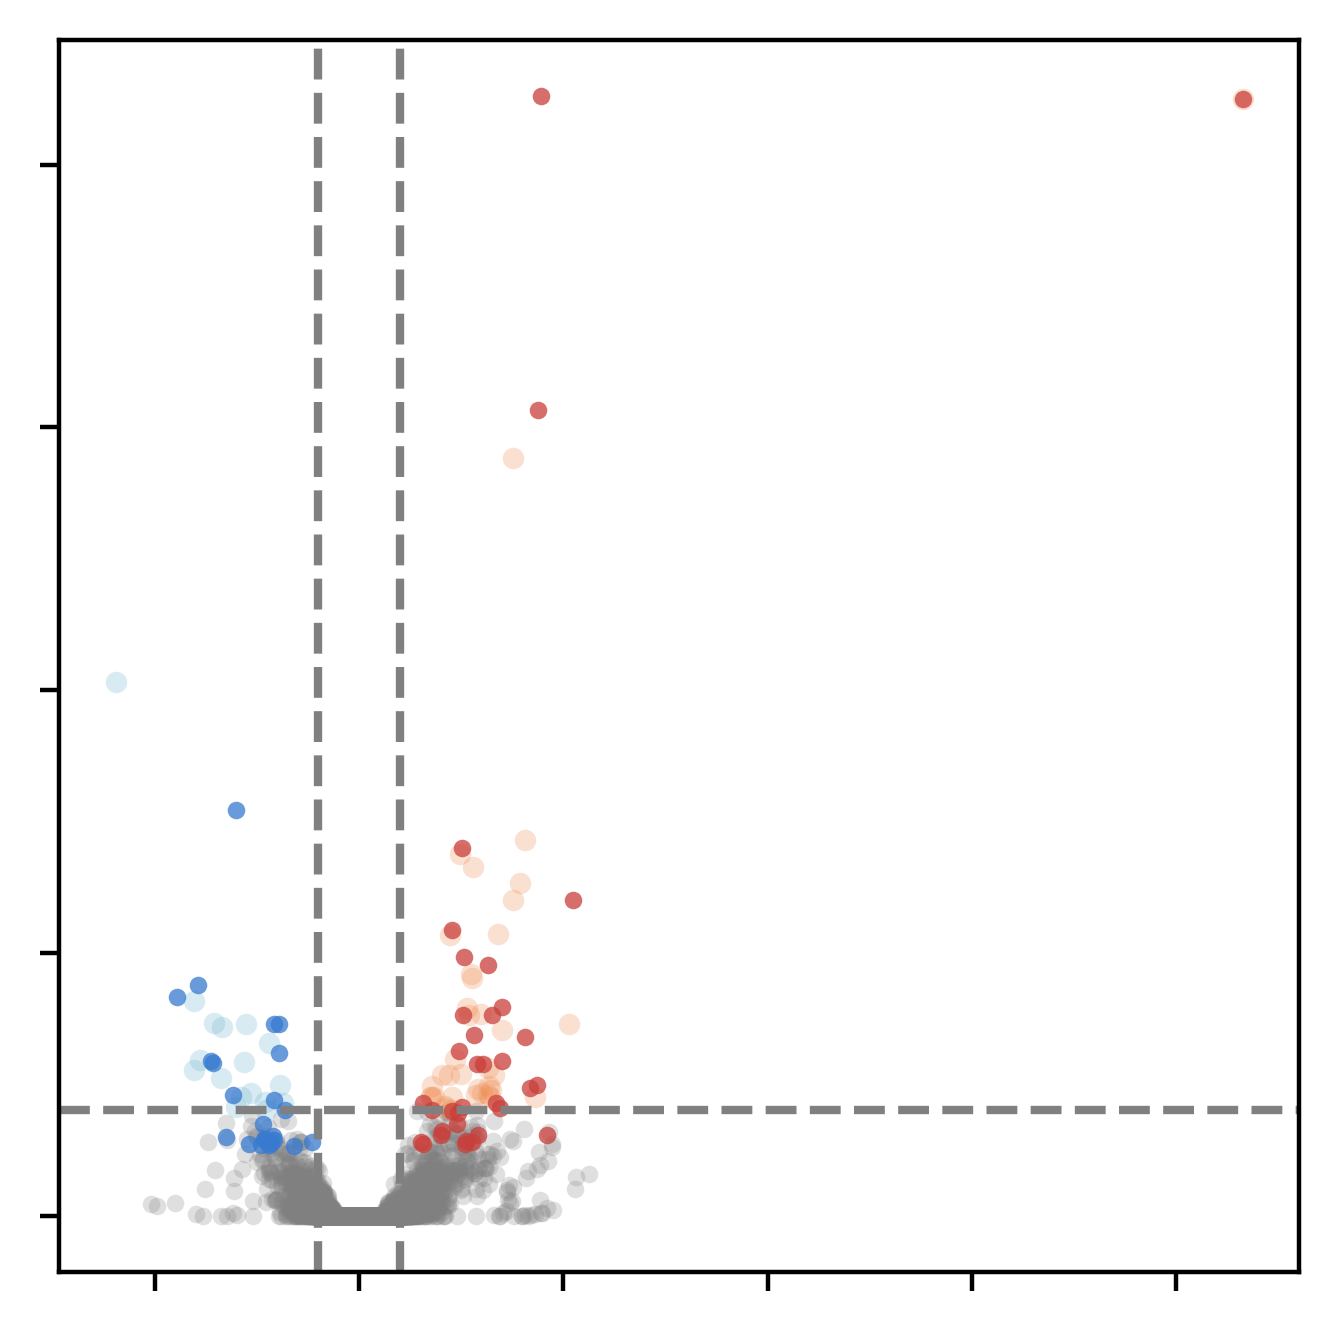

In [710]:
# Chen_DEGs_oi = Chen_DEGs[(Chen_DEGs['MSI_class']=='High') & (Chen_DEGs['gene'].isin(Joanito_DEGs_oi['gene']))].copy()

plt.figure(figsize=(4, 4), dpi=400)

up = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_up)]
down = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_down)]

up2 = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['log2FoldChange']>=2) & (chen_tumor_DEG_summary['padj']<=0.01)]
up2 = up2[~up2['gene'].isin(up['gene'])]
down2 = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['log2FoldChange']<=-2)&(chen_tumor_DEG_summary['padj']<=0.01)]
down2 = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
genes_to_exclude = set(up['gene']).union(set(down['gene'])).union( set(up2['gene']).union(set(down2['gene'])) )
    
ax = sns.scatterplot(x=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(genes_to_exclude))]['log2FoldChange'], 
                y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(genes_to_exclude))]['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['log2FoldChange'],y=down2['padj'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.25, **{'linewidths':0})
ax = sns.scatterplot(x=up2['log2FoldChange'],y=up2['padj'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.25,  **{'linewidths':0})


ax = sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})


ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-8.5, 10]);

In [713]:
up.sort_values('log2FoldChange', ascending=False).head(10)[['gene', 'log2FoldChange', 'padj']]

gene  log2FoldChange          padj
8621    LINC02418       43.280851  5.634290e-22
9755         MUC6       10.491486  1.010297e-06
7694         IRX2        9.206600  2.882378e-02
13448       SMOC2        8.897491  4.876253e-22
6661        GNGT1        8.751264  4.745805e-16
1107   AC104383.2        8.689618  3.216345e-03
13357      SLFN13        8.364034  3.717778e-03
1327   AC215522.2        8.133489  4.019109e-04
7508        IGSF1        6.978561  1.064507e-04
7487      IGKV1-5        6.976790  1.142531e-03

In [714]:
down.sort_values('log2FoldChange', ascending=False).head(10)[['gene', 'log2FoldChange', 'padj']]

gene  log2FoldChange      padj
5302       DST       -2.303417  0.039927
4274     CLCF1       -3.174544  0.048495
14779    TNNT1       -3.650445  0.009851
12602   S100A2       -3.908577  0.000808
9466     MMP28       -3.945935  0.000223
5903   FAM155A       -4.176947  0.037161
10768   PCED1B       -4.189988  0.000223
8237    LGALS1       -4.190842  0.006387
8932       LYZ       -4.206828  0.030902
13323   SLC7A7       -4.329964  0.042519

In [514]:
import matplotlib

In [524]:
sns.color_palette('icefire_r', 8)

[(0.93850535, 0.52748892, 0.28242464),
 (0.78979746, 0.24694858, 0.22678822),
 (0.47151732, 0.17401641, 0.24610337),
 (0.19884415, 0.12394381, 0.1385669),
 (0.14254381, 0.14016944, 0.18944326),
 (0.2659204, 0.25949691, 0.511417),
 (0.2157176, 0.47827123, 0.81487615),
 (0.42110294, 0.69916972, 0.80506683)]

In [563]:
palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=300, sharey=False, sharex=True,)
ax = sc.pl.violin(adata_epi_chen_tumor_copy, keys='UP', groupby='MSI_class', 
            palette={'MSI-L' : palette_e[-1], 'MSI-I' : 'gray', 'MSI-H' : palette_e[0]}, order=['MSI-L', 'MSI-I', 'MSI-H'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
ax.set_xticklabels([]);
ax.set_xlabel('');
# ax.set_yticklabels([]);
ax.set_ylabel('');

ax = sc.pl.violin(adata_epi_chen_tumor_copy, keys='DW', groupby='MSI_class', 
            palette={'MSI-L' : palette_e[-1], 'MSI-I' : 'gray', 'MSI-H' : palette_e[0]}, order=['MSI-L', 'MSI-I', 'MSI-H'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
ax.set_xticklabels([]);
ax.set_xlabel('');
# ax.set_yticklabels([]);
ax.set_ylabel('');



In [562]:
palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=300, sharey=False, sharex=True,)
ax = sc.pl.violin(adata_epi_joanito_tumor_copy, keys='UP', groupby='MSI_class', 
            palette={'MSI-L' : palette_e[-1], 'MSI-I' : 'gray', 'MSI-H' : palette_e[0]}, order=['MSI-L', 'MSI-I', 'MSI-H'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
ax.set_xticklabels([]);
ax.set_xlabel('');
# ax.set_yticklabels([]);
ax.set_ylabel('');
# ax.set_xticks([]);

ax = sc.pl.violin(adata_epi_joanito_tumor_copy, keys='DW', groupby='MSI_class', 
            palette={'MSI-L' : palette_e[-1], 'MSI-I' : 'gray', 'MSI-H' : palette_e[0]}, order=['MSI-L', 'MSI-I', 'MSI-H'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
ax.set_xticklabels([]);
ax.set_xlabel('');
# ax.set_yticklabels([]);
ax.set_ylabel('');

## S100 family & Relevant genes

In [ ]:
dict_region_to_S100_gene = {
    # '1q21' : [f'S100A{i}' for i in range(1, 18+1)] + ['TCHH', 'FLG', 'RPTN'],
    '1q21' : ['S100A2', 'S100A4', 'S100A6', 'S100A2', 'S100A10', 'S100A11', 'S100A13', 'S100A14',],
    '4p16' : ['S100P'],}

In [727]:
S100_family = list()
for gene in joanito_tumor_DEG_summary['gene']:
    if 'S100' in gene:
        S100_family.append(gene)
S100_family

uncorrelated_S100 = [
    'S100A1',
    'S100A13',
    ''
]
len(S100_family)

15

In [1022]:
for gene in intersecting_up:
    print(gene)

IGKV1-17
AC132807.2
CCDC26
NRXN3
NUPR1
AC090709.1
IGKV1-5
SLFN13
KCNMB4
LRP4
IRX2
MUC6
LINC02418
ABCB1
F11-AS1
RGMB
BBOX1-AS1
GNGT1
SMOC2
AMBP
AC007128.2
LINC01967
CD302
AC215522.2
IGFBP3
IGSF1
BMP7
SYT1
RUBCNL
SLC26A3
FREM1
TRPS1
AC104383.2
ASCL2
AC006206.2
CYP4X1


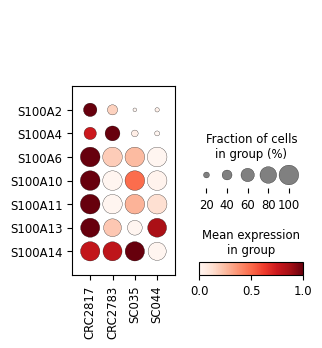

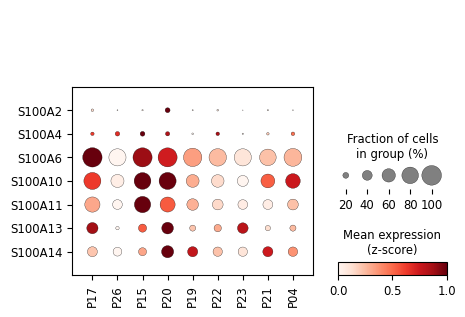

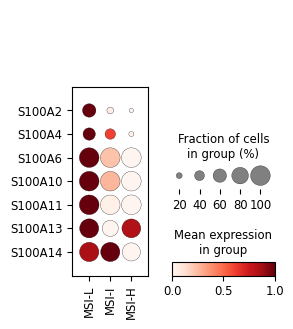

In [832]:
genes_of_interest = ['MLH1', 'MSH2', 'MSH6', 'PMS2', ]
genes_of_interest = ['S100A2', 'S100A4', 'S100A6', 'S100A10', 'S100A11', 'S100A13', 'S100A14',]
# genes_of_interest = ['AHR']

with matplotlib.rc_context(rc={'figure.dpi': 100, 'figure.figsize': (4, 3)}):
    sc.pl.dotplot(adata_epi_joanito_tumor, 
                var_names=genes_of_interest, 
                groupby='PatientID', 
                categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True, standard_scale='var',)
    sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
                var_names=genes_of_interest, 
                groupby='PatientID', 
                categories_order=[p for p in chen_patient_order_by_MSI_intensity if p !='P18'], swap_axes=True, standard_scale='var', colorbar_title='Mean expression\n(z-score)')

with matplotlib.rc_context(rc={'figure.dpi': 100, 'figure.figsize': (4, 3)}):
    sc.pl.dotplot(adata_epi_joanito_tumor, 
                var_names=genes_of_interest, 
                groupby='MSI_class', 
                categories_order=['MSI-L', 'MSI-I', 'MSI-H'], swap_axes=True, standard_scale='var',)
    sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
                var_names=genes_of_interest, 
                groupby='MSI_class', 
                categories_order=['MSI-L', 'MSI-I', 'MSI-H'], swap_axes=True, standard_scale='var',)

In [863]:
chen_fetal_signature = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/fetal_signature.txt', header=None,)
chen_metaplasia_signature = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/metaplasia_signature.txt', header=None)
chen_stem_signature = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/wnt_stem_signature.txt', header=None)

chen_fetal_signature.columns = ['gene']
chen_metaplasia_signature.columns = ['gene']
chen_stem_signature.columns = ['gene']

sc.tl.score_genes(adata_epi_chen_tumor, chen_fetal_signature['gene'], score_name='Fetal_signature')
sc.tl.score_genes(adata_epi_joanito_tumor, chen_fetal_signature['gene'], score_name='Fetal_signature')

sc.tl.score_genes(adata_epi_chen_tumor, chen_metaplasia_signature['gene'], score_name='Metaplasia_signature')
sc.tl.score_genes(adata_epi_joanito_tumor, chen_metaplasia_signature['gene'], score_name='Metaplasia_signature')

sc.tl.score_genes(adata_epi_chen_tumor, chen_stem_signature['gene'], score_name='Stem_signature')
sc.tl.score_genes(adata_epi_joanito_tumor, chen_stem_signature['gene'], score_name='Stem_signature')

In [898]:
adata_epi_chen_tumor_subset = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.index.isin( list(chen_fetal_signature['gene'])+list(chen_metaplasia_signature['gene'])+list(chen_stem_signature['gene']) )].copy()
sc.pp.normalize_total(adata_epi_chen_tumor_subset)
sc.pp.log1p(adata_epi_chen_tumor_subset)
sc.pp.scale(adata_epi_chen_tumor_subset, max_value=10)

sc.tl.pca(adata_epi_chen_tumor_subset)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [902]:
sc.pp.neighbors(adata_epi_chen_tumor_subset, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_chen_tumor_subset,)

In [915]:
sc.tl.score_genes(adata_epi_chen_tumor_subset, chen_fetal_signature['gene'], score_name='Fetal_signature')
sc.tl.score_genes(adata_epi_chen_tumor_subset, chen_metaplasia_signature['gene'], score_name='Metaplasia_signature')
sc.tl.score_genes(adata_epi_chen_tumor_subset, chen_stem_signature['gene'], score_name='Stem_signature')

In [913]:
adata_epi_chen_tumor_subset.raw = adata_epi_chen_tumor_subset

In [923]:
sc.pl.pca(adata_epi_chen_tumor_subset, color=['Stem_signature', 'Metaplasia_signature', 'Fetal_signature'], use_raw=False, cmap='rocket', vmin=0, vmax=1 )

In [ ]:
adata_epi_joanito_tumor_subset = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.index.isin( list(chen_fetal_signature['gene'])+list(chen_metaplasia_signature['gene'])+list(chen_stem_signature['gene']) )].copy()
sc.pp.normalize_total(adata_epi_chen_tumor_subset)
sc.pp.log1p(adata_epi_chen_tumor_subset)
sc.pp.scale(adata_epi_chen_tumor_subset, max_value=10)

sc.tl.pca(adata_epi_chen_tumor_subset)

In [867]:
sc.pl.dotplot(adata_epi_joanito_tumor, var_names=['Fetal_signature', 'Metaplasia_signature', 'Stem_signature'], groupby='MSI_class', standard_scale='var',)
sc.pl.dotplot(adata_epi_chen_tumor, var_names=['Fetal_signature', 'Metaplasia_signature', 'Stem_signature'], groupby='MSI_class', standard_scale='var',)

In [887]:
u, s = np.mean(adata_epi_chen_tumor.obs['MSI_score']), np.std(adata_epi_chen_tumor.obs['MSI_score'])
adata_epi_chen_tumor.obs['MSI_score_z'] = [ (ms-u)/s for ms in adata_epi_chen_tumor.obs['MSI_score'] ]

u, s = np.mean(adata_epi_chen_tumor.obs['Stem_signature']), np.std(adata_epi_chen_tumor.obs['Stem_signature'])
adata_epi_chen_tumor.obs['Stem_signature_score_z'] = [ (ms-u)/s for ms in adata_epi_chen_tumor.obs['Stem_signature'] ]

u, s = np.mean(adata_epi_chen_tumor.obs['Metaplasia_signature']), np.std(adata_epi_chen_tumor.obs['Metaplasia_signature'])
adata_epi_chen_tumor.obs['Metaplasia_signature_z'] = [ (ms-u)/s for ms in adata_epi_chen_tumor.obs['Metaplasia_signature'] ]

In [891]:
sns.scatterplot(data=adata_epi_chen_tumor.obs.sample(10000, random_state=42), x='Metaplasia_signature_z', y='MSI_score_z', 
                hue='MSI_class', alpha=0.5, **{'linewidths':0},
                )

<Axes: xlabel='Metaplasia_signature_z', ylabel='MSI_score_z'>

<Axes: xlabel='MSI_class', ylabel='Fetal_signature'>

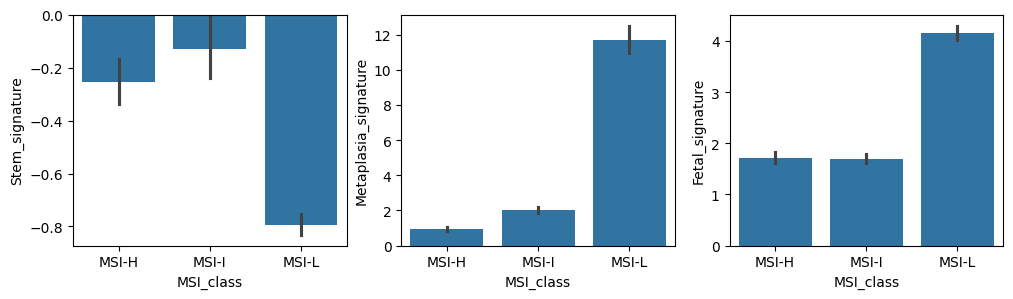

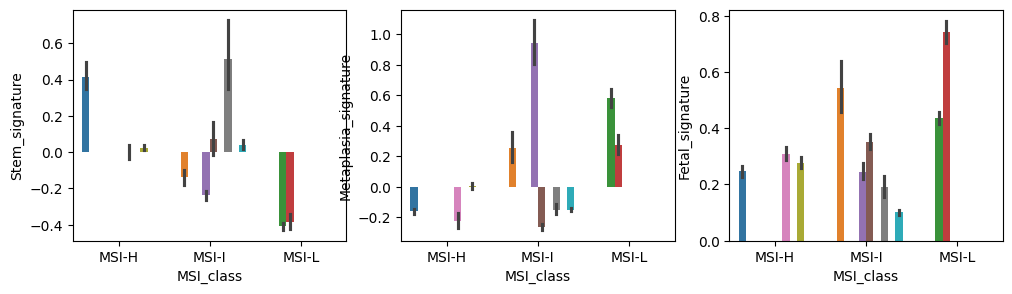

In [930]:
fig ,axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
sns.barplot(data=adata_epi_joanito_tumor.obs, y='Stem_signature', x='MSI_class', ax=axes[0])
sns.barplot(data=adata_epi_joanito_tumor.obs, y='Metaplasia_signature', x='MSI_class', ax=axes[1])
sns.barplot(data=adata_epi_joanito_tumor.obs, y='Fetal_signature', x='MSI_class', ax=axes[2])

fig ,axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
sns.barplot(data=adata_epi_chen_tumor.obs, y='Stem_signature', x='MSI_class', hue='PatientID', legend=None,ax=axes[0])
sns.barplot(data=adata_epi_chen_tumor.obs, y='Metaplasia_signature', x='MSI_class', hue='PatientID', legend=None,ax=axes[1])
sns.barplot(data=adata_epi_chen_tumor.obs, y='Fetal_signature', x='MSI_class', hue='PatientID', legend=None, ax=axes[2])

In [828]:
sc.tl.score_genes(adata_epi_chen_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='E.Secretory_All')& (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_SecretoryAll')
sc.tl.score_genes(adata_epi_chen_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='E.Absorptive_All')& (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_AbsortiveAll')
sc.tl.score_genes(adata_epi_chen_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='Stem') & (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_Stem')


sc.tl.score_genes(adata_epi_joanito_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='E.Secretory_All')& (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_SecretoryAll')
sc.tl.score_genes(adata_epi_joanito_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='E.Absorptive_All')& (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_AbsortiveAll')
sc.tl.score_genes(adata_epi_joanito_tumor, smillie_epi_marker[(smillie_epi_marker['ident']=='Stem') & (smillie_epi_marker['padjC']<=0.05)]['gene'], score_name='Smillie_Stem')

       'RPSAP58'],
      dtype='object')
       'RPS3A', 'RPL5', 'RPSA', 'RP11-290L1.2', 'GYLTL1B', 'RPS6', 'RPL31',
       'RPS4X', 'RPS21', 'AP000344.3', 'RPS9', 'RPLP0', 'RPL14', 'NGFRAP1',
       'RPSAP58'],
      dtype='object')


In [843]:
# sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], var_names=['Smillie_AbsortiveAll', 'Smillie_SecretoryAll', 'Smillie_Stem'], groupby='MSI_class', standard_scale='var',)
# sc.pl.dotplot(adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['PatientID']!='P18'], var_names=['Smillie_AbsortiveAll', 'Smillie_SecretoryAll', 'Smillie_Stem'], groupby='MSI_class', standard_scale='var',)

sns.kdeplot(data=adata_epi_chen_tumor.obs[(adata_epi_chen_tumor.obs['PatientID']!='P18')], x='Smillie_Stem', hue='MSI_class', common_norm=False,)

<Axes: xlabel='Smillie_Stem', ylabel='Density'>

## Compare Scanpy DEG results and PyDESeq2 DEG results

In [137]:
Joanito_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
Joanito_scanpy_DEGs = Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['MSI_class']=='MSI_H') & (Joanito_scanpy_DEGs['adjusted_pvalue']<=0.05)]
Joanito_scanpy_DEGs.reset_index(inplace=True, drop=True)
Joanito_pydeseq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Joanito_pydeseq2_DEGs.columns = ['gene'] + list(Joanito_pydeseq2_DEGs.columns)[1:]
Joanito_pydeseq2_DEGs.sort_values('stat',  ascending=False, inplace=True)

Chen_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
Chen_scanpy_DEGs = Chen_scanpy_DEGs[(Chen_scanpy_DEGs['MSI_class']=='MSI_H') & (Chen_scanpy_DEGs['adjusted_pvalue']<=0.05)]
Chen_scanpy_DEGs.reset_index(inplace=True, drop=True)
Chen_pydeseq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Chen_pydeseq2_DEGs.columns = ['gene'] + list(Chen_pydeseq2_DEGs.columns)[1:]
Chen_pydeseq2_DEGs.sort_values('stat', ascending=False, inplace=True)

In [144]:
np.mean(Joanito_pydeseq2_DEGs['baseMean'])

99.24442702514892

In [155]:
plt.figure(figsize=(6, 8), dpi=400)

down = Joanito_pydeseq2_DEGs[(Joanito_pydeseq2_DEGs['baseMean']>=np.mean(Joanito_pydeseq2_DEGs['baseMean'])) & (Joanito_pydeseq2_DEGs['log2FoldChange']<=-2)&(Joanito_pydeseq2_DEGs['padj']<=0.01)]
up = Joanito_pydeseq2_DEGs[(Joanito_pydeseq2_DEGs['baseMean']>=np.mean(Joanito_pydeseq2_DEGs['baseMean'])) & (Joanito_pydeseq2_DEGs['log2FoldChange']>=2)&(Joanito_pydeseq2_DEGs['padj']<=0.01)]

nonSigGenes = [ gene for gene in Joanito_pydeseq2_DEGs['gene'] if gene not in set(down['gene']).union(set(up['gene'])) ]
sns.scatterplot(x=Joanito_pydeseq2_DEGs[(Joanito_pydeseq2_DEGs['gene'].isin(nonSigGenes))]['log2FoldChange'], 
                y=Joanito_pydeseq2_DEGs[(Joanito_pydeseq2_DEGs['gene'].isin(nonSigGenes))]['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.1, 
                color='gray',
                )

sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), 
                # s=5, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=.75,)
sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), 
                # s=5,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=.75,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

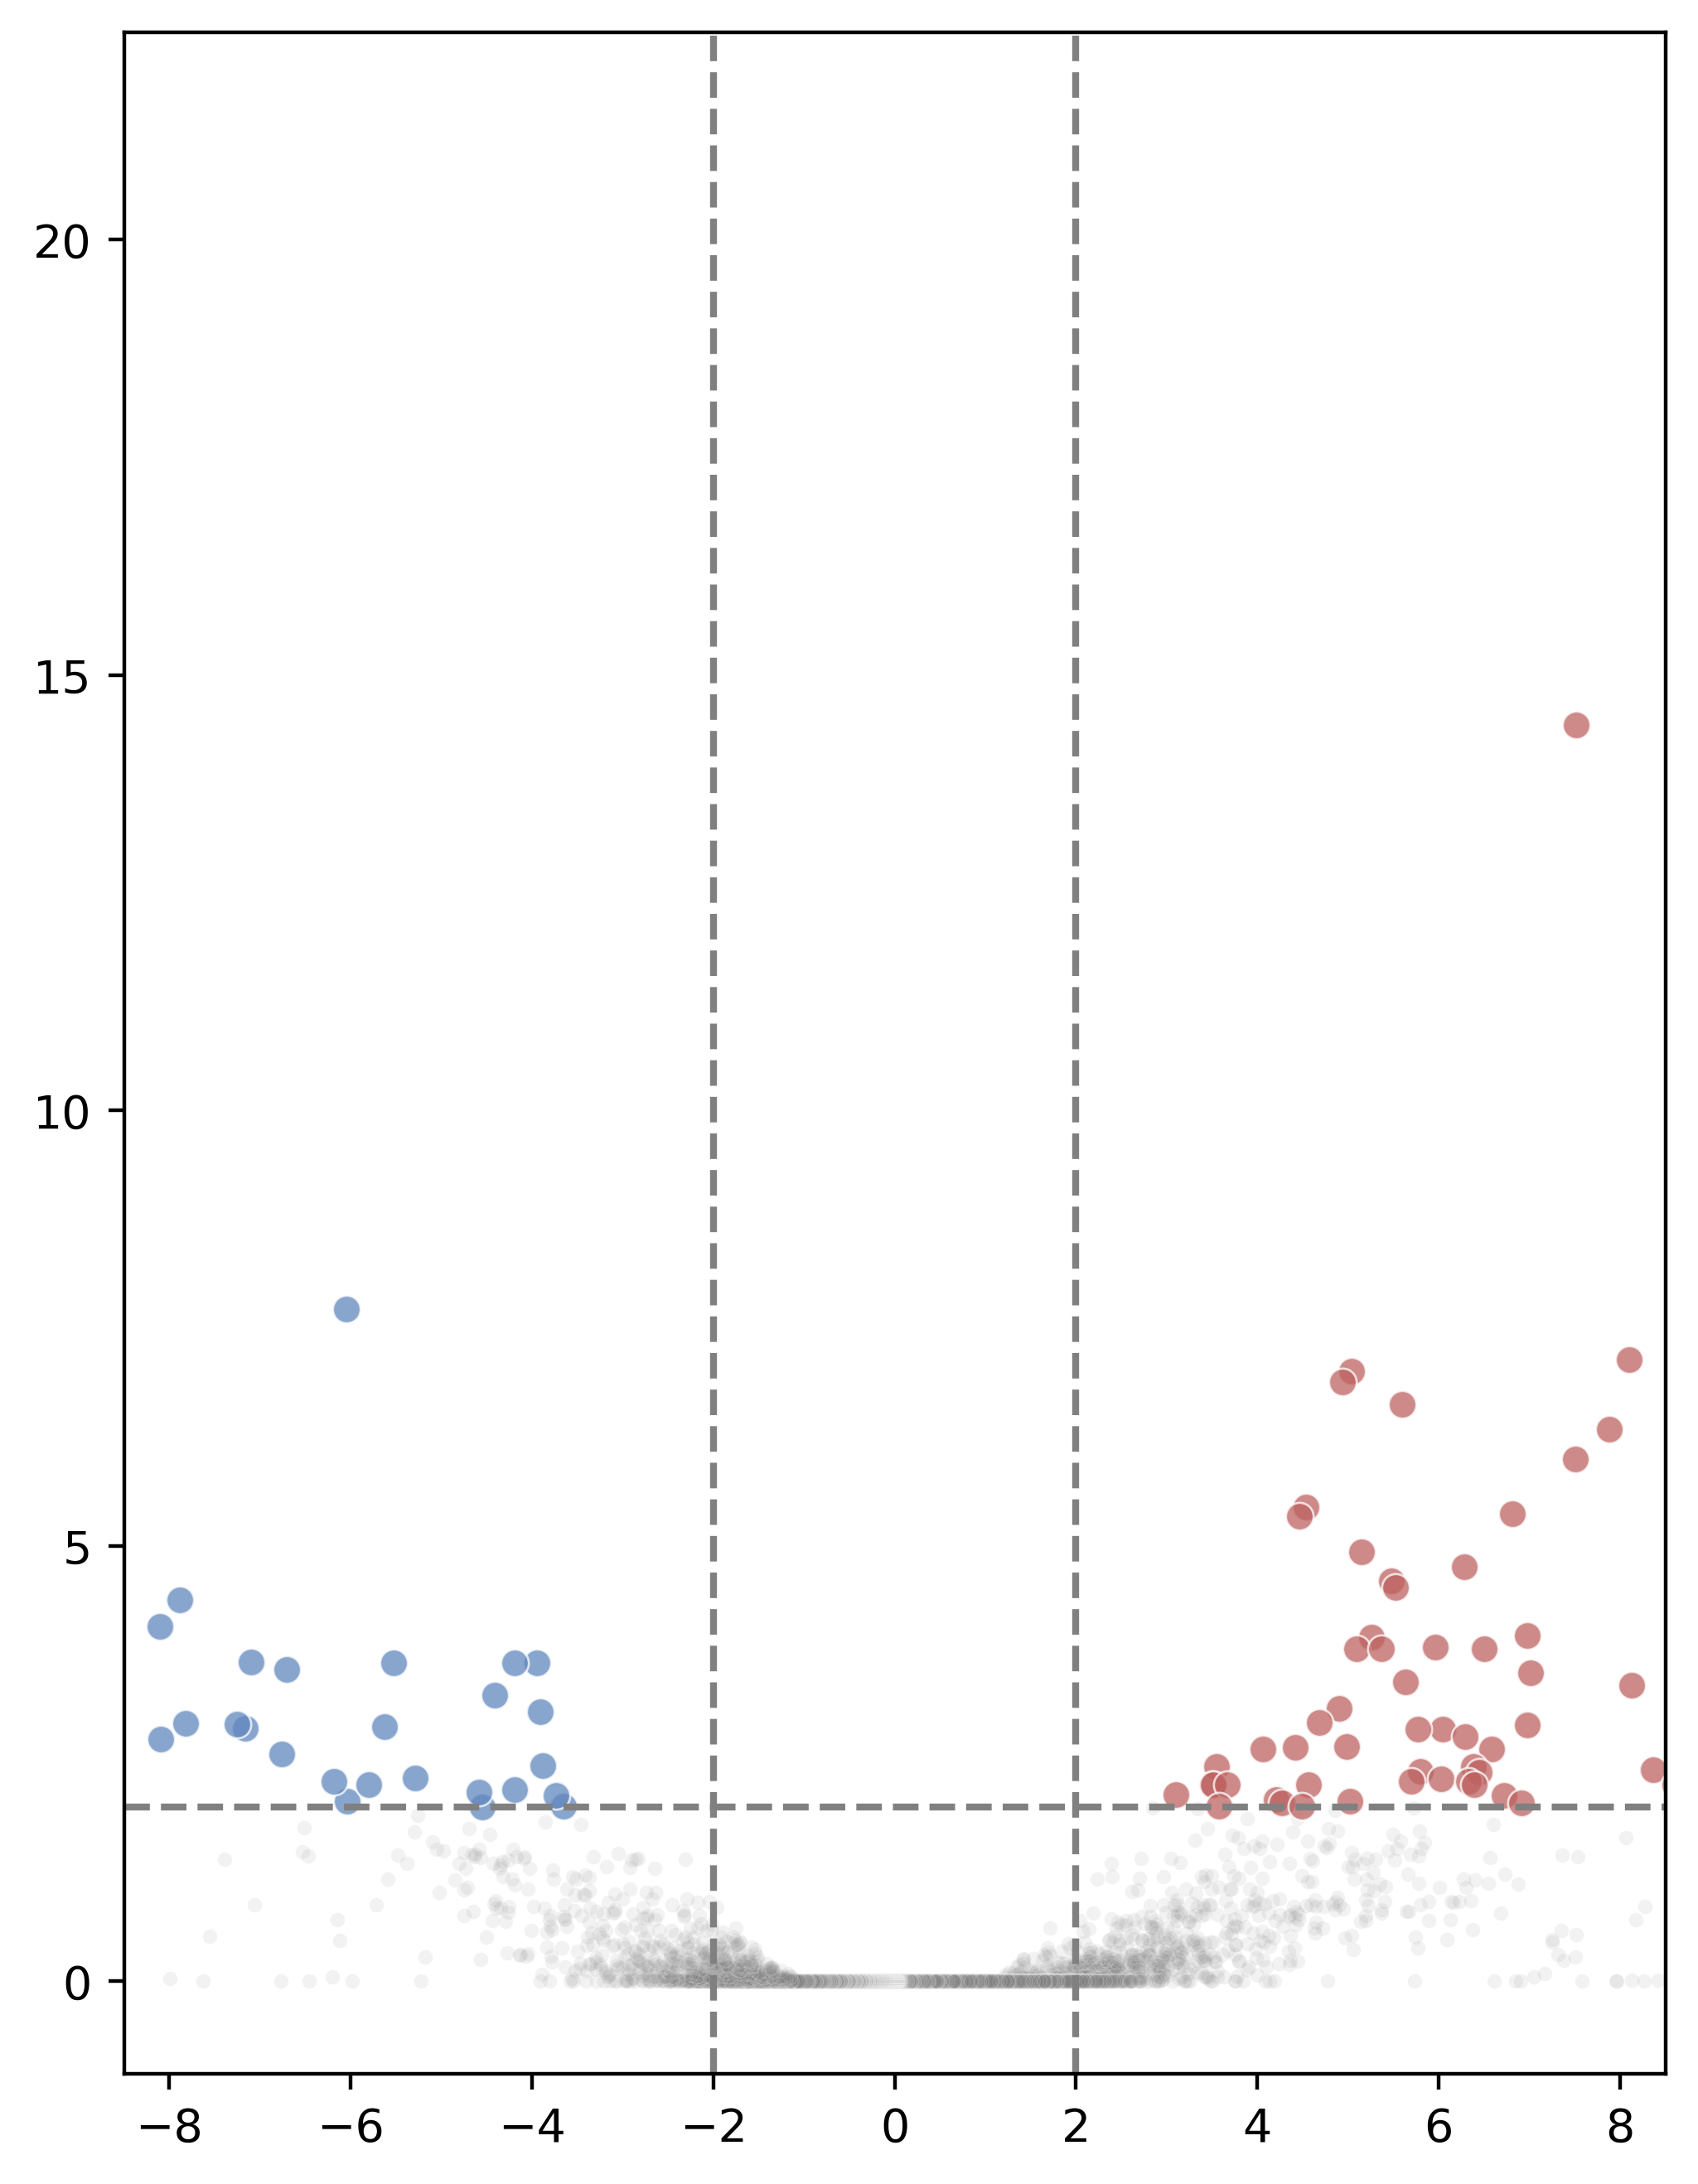

In [163]:
plt.figure(figsize=(6, 8), dpi=400)

down = Chen_pydeseq2_DEGs[(Chen_pydeseq2_DEGs['baseMean']>=np.mean(Chen_pydeseq2_DEGs['baseMean'])) & (Chen_pydeseq2_DEGs['log2FoldChange']<=-1)&(Chen_pydeseq2_DEGs['padj']<=0.01)]
up = Chen_pydeseq2_DEGs[(Chen_pydeseq2_DEGs['baseMean']>=np.mean(Chen_pydeseq2_DEGs['baseMean'])) & (Chen_pydeseq2_DEGs['log2FoldChange']>=1)&(Chen_pydeseq2_DEGs['padj']<=0.01)]

nonSigGenes = [ gene for gene in Chen_pydeseq2_DEGs['gene'] if gene not in set(down['gene']).union(set(up['gene'])) ]
sns.scatterplot(x=Chen_pydeseq2_DEGs[(Chen_pydeseq2_DEGs['gene'].isin(nonSigGenes))]['log2FoldChange'], 
                y=Chen_pydeseq2_DEGs[(Chen_pydeseq2_DEGs['gene'].isin(nonSigGenes))]['padj'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.1, 
                color='gray',
                )

sns.scatterplot(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)), 
                # s=5, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=.75,)
sns.scatterplot(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)), 
                # s=5,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=.75,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

In [183]:
a = set(Joanito_pydeseq2_DEGs[(Joanito_pydeseq2_DEGs['padj']<=0.05) & (Joanito_pydeseq2_DEGs['log2FoldChange']<=-1)].sort_values('log2FoldChange')['gene'])
b = set(Chen_pydeseq2_DEGs[(Chen_pydeseq2_DEGs['padj']<=0.05) & (Chen_pydeseq2_DEGs['log2FoldChange']<=-1)].sort_values('log2FoldChange')['gene'])

b

{'AC008514.1',
 'AC048352.1',
 'AC073365.1',
 'AC108865.1',
 'AC112487.1',
 'ADAMTS6',
 'AKR1C1',
 'AKR1C2',
 'AL033504.1',
 'AL035446.2',
 'AL137800.1',
 'AL359636.2',
 'AL445123.2',
 'AMIGO2',
 'ANXA10',
 'ARL4C',
 'CLCF1',
 'CPED1',
 'CPNE8',
 'CTXN1',
 'DCT',
 'DEFB1',
 'DIO3OS',
 'DKK1',
 'DSG3',
 'DST',
 'F5',
 'FAM155A',
 'FKBP10',
 'GRM8',
 'HSD17B2',
 'IL1RAPL1',
 'ITGA9',
 'KRT16',
 'L1TD1',
 'LGALS1',
 'LINC02474',
 'LINC02832',
 'LRP12',
 'LY6G6D',
 'LYZ',
 'MANCR',
 'MGP',
 'MMP28',
 'ONECUT3',
 'PCED1B',
 'PRAC1',
 'PRDM8',
 'PTHLH',
 'RAB32',
 'S100A2',
 'SAMD5',
 'SELL',
 'SERPINB2',
 'SFTA2',
 'SLC38A5',
 'SLC7A7',
 'ST3GAL6',
 'TCEA2',
 'TMEM200A',
 'TNNC2',
 'TNNT1',
 'VSIG2',
 'WASF3',
 'XACT',
 'ZFPM2'}

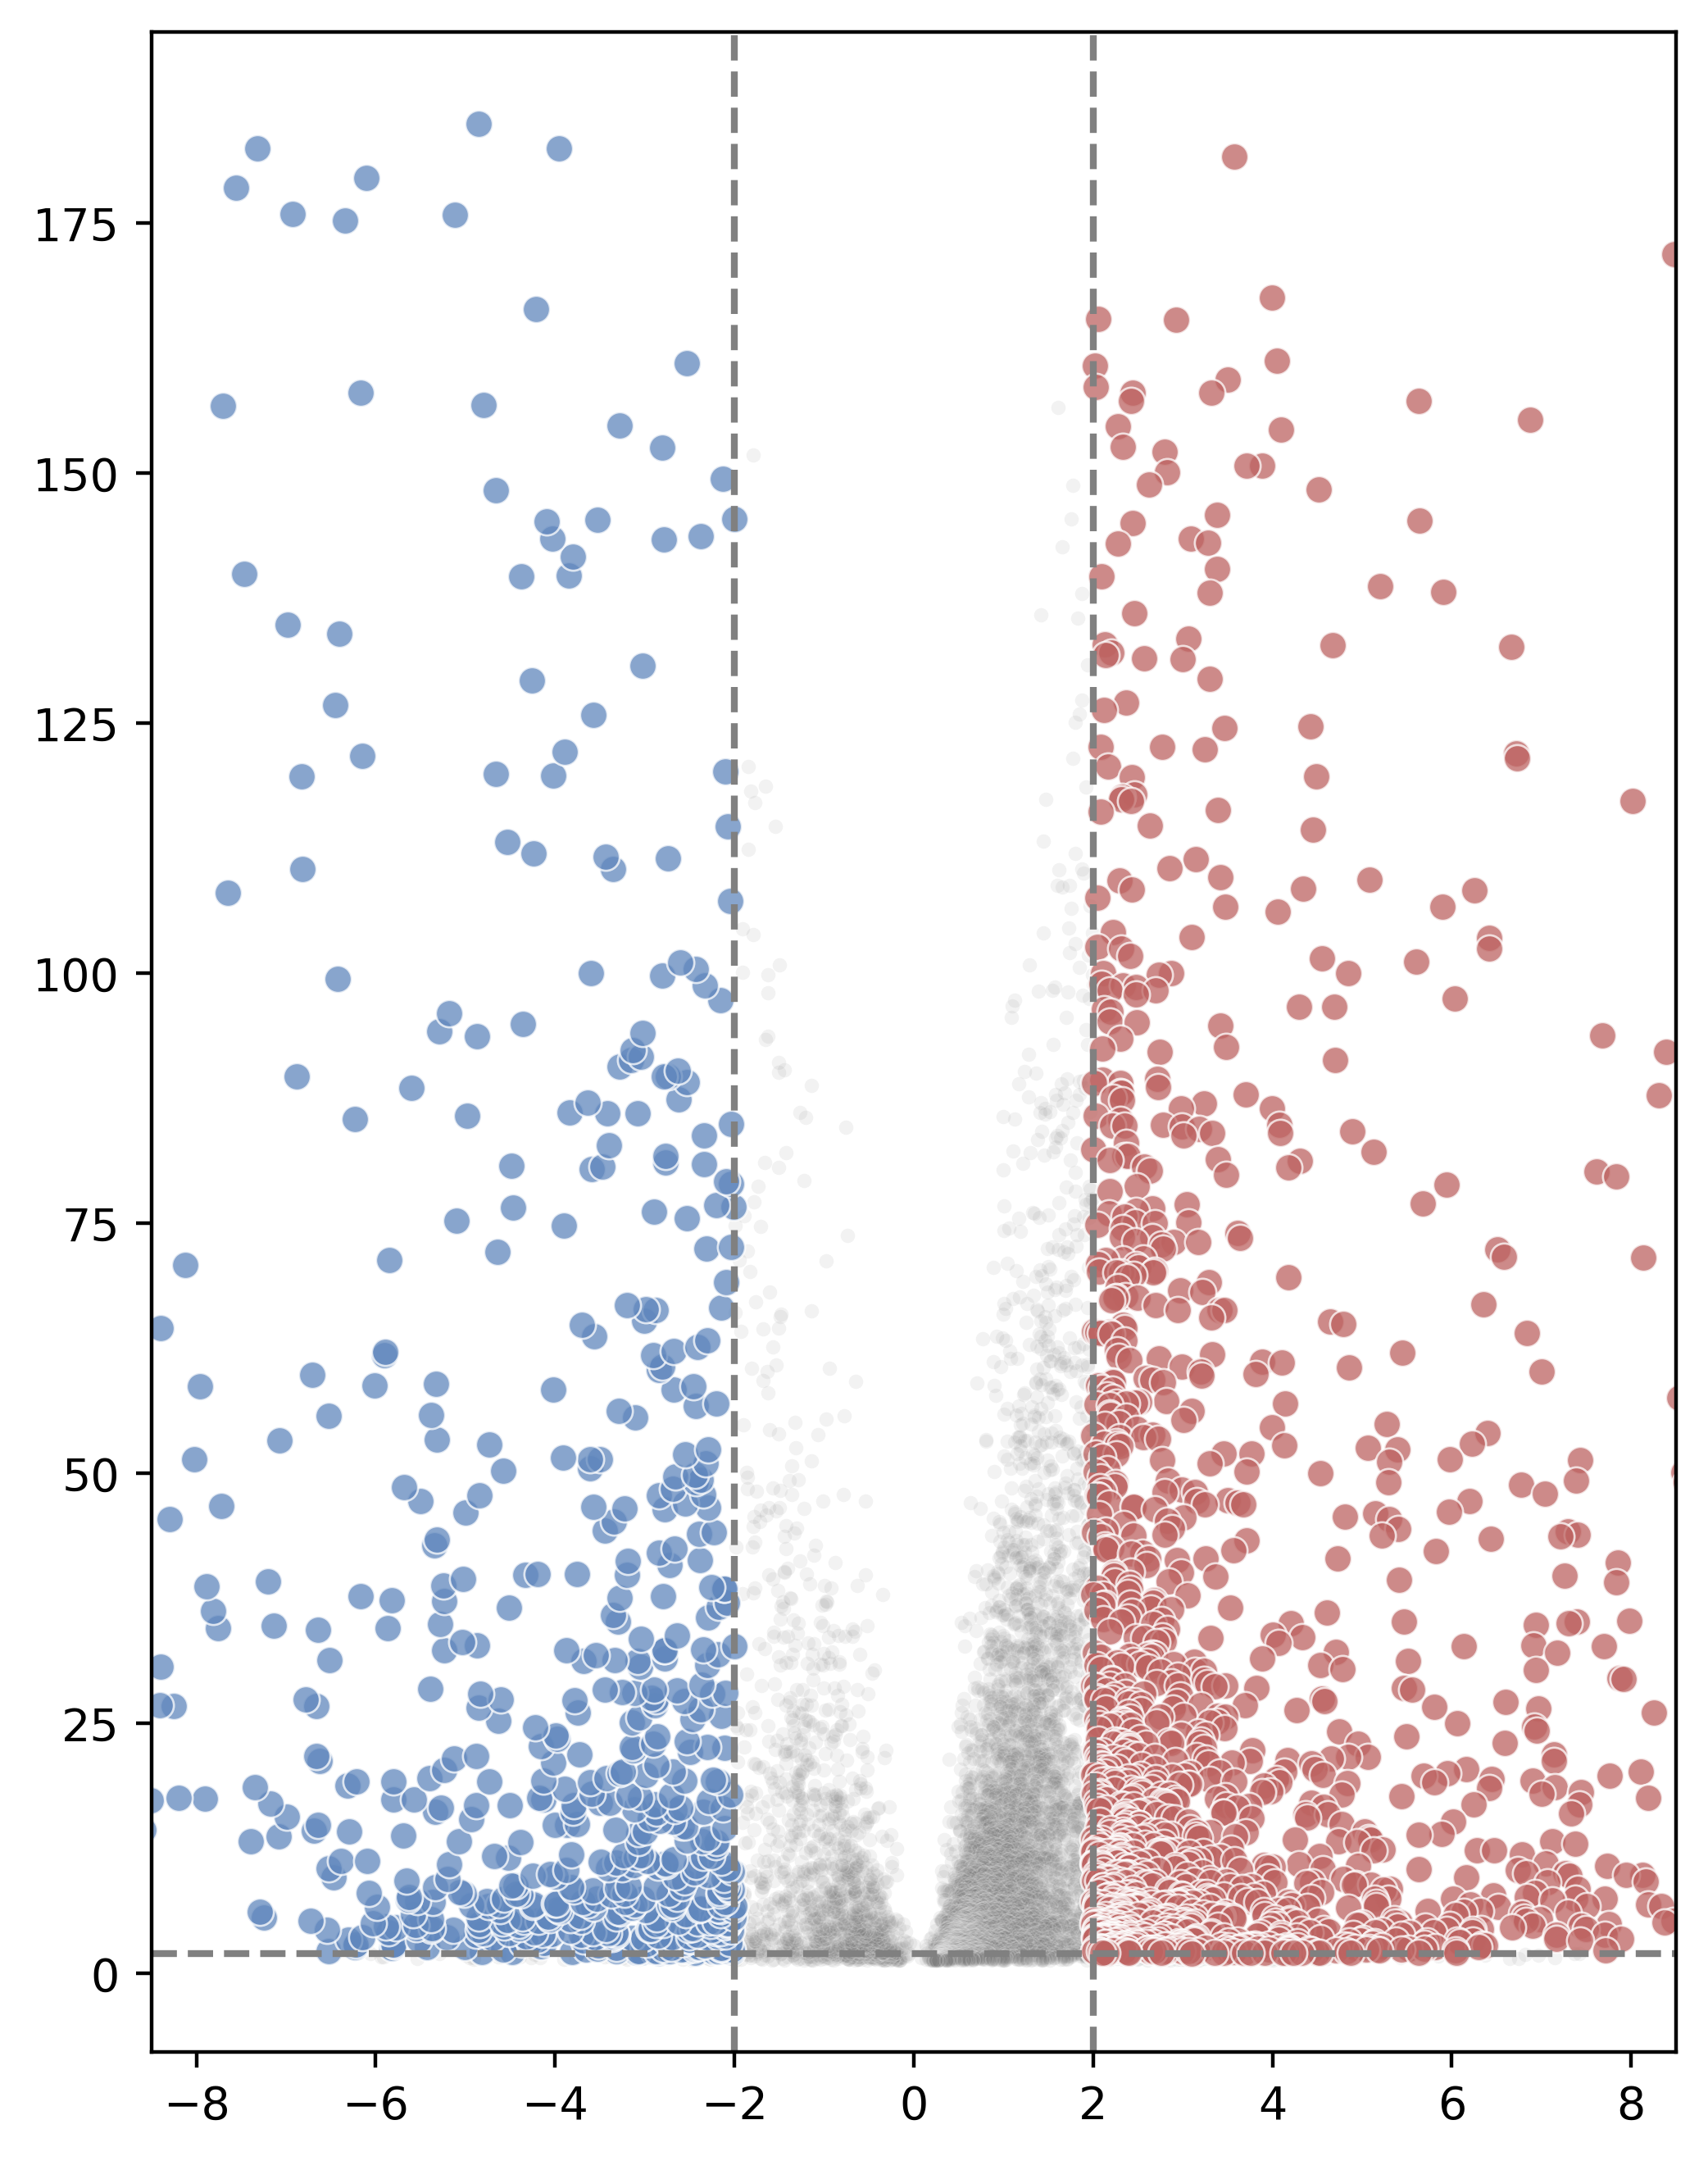

In [170]:
plt.figure(figsize=(6, 8), dpi=400)

Joanito_scanpy_DEGs['logAdjPval'] = [ -np.log10(adjp) for adjp in Joanito_scanpy_DEGs['adjusted_pvalue'] ]

down = Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['logfoldchanges']<=-2)&(Joanito_scanpy_DEGs['adjusted_pvalue']<=0.01)]
up = Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['logfoldchanges']>=2)&(Joanito_scanpy_DEGs['adjusted_pvalue']<=0.01)]

nonSigGenes = [ gene for gene in Joanito_scanpy_DEGs['gene'] if gene not in set(down['gene']).union(set(up['gene'])) ]
sns.scatterplot(x=Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['gene'].isin(nonSigGenes))]['logfoldchanges'], 
                y=Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['gene'].isin(nonSigGenes))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.1, 
                color='gray',
                )

sns.scatterplot(x=down['logfoldchanges'],y=down['logAdjPval'], 
                # s=5, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=.75,)
sns.scatterplot(x=up['logfoldchanges'],y=down['logAdjPval'], 
                # s=5,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=.75,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

### MSI-H

In [616]:
n_genes = 100
Chen_scanpy_DEGs_top = set(Chen_scanpy_DEGs.iloc[0:n_genes]['gene'])
Chen_pydeseq2_DEGs_top = set(Chen_pydeseq2_DEGs.iloc[0:n_genes]['gene'])

jaccard_similarity(Chen_scanpy_DEGs_top, Chen_pydeseq2_DEGs_top)

0.09289617486338798

In [617]:
Chen_intersecting_genes = Chen_scanpy_DEGs_top.intersection(Chen_pydeseq2_DEGs_top)

In [618]:
n_genes = 100
Joanito_scanpy_DEGs_top = set(Joanito_scanpy_DEGs.iloc[0:n_genes]['gene'])
Joanito_pydeseq2_DEGs_top = set(Joanito_pydeseq2_DEGs.iloc[0:n_genes]['gene'])

jaccard_similarity(Joanito_scanpy_DEGs_top, Joanito_pydeseq2_DEGs_top)

0.22699386503067484

In [619]:
Joanito_intersecting_genes = Joanito_scanpy_DEGs_top.intersection(Joanito_pydeseq2_DEGs_top)

In [620]:
for gene in Chen_intersecting_genes.intersection(Joanito_intersecting_genes):
    print(gene)

GNGT1
RGMB
ASCL2
NUPR1


### MSI-L

In [608]:
Chen_scanpy_DEGs[Chen_scanpy_DEGs['gene']=='PRAC1']

gene      score  logfoldchanges  pvalue  adjusted_pvalue MSI_class
7414  PRAC1 -39.280502        -9.81365     0.0              0.0     MSI_H

In [609]:
Chen_pydeseq2_DEGs[Chen_pydeseq2_DEGs['gene']=='PRAC1']

gene    baseMean  log2FoldChange     lfcSE      stat        pvalue  \
11509  PRAC1  684.270446      -11.913933  1.563446 -7.620306  2.530753e-14   

               padj  
11509  6.976442e-11

In [610]:
n_genes = 200
Chen_scanpy_DEGs_top = set(Chen_scanpy_DEGs.iloc[-n_genes:]['gene'])
Chen_pydeseq2_DEGs_top = set(Chen_pydeseq2_DEGs.iloc[-n_genes:]['gene'])

jaccard_similarity(Chen_scanpy_DEGs_top, Chen_pydeseq2_DEGs_top)

0.08695652173913043

In [611]:
Chen_intersecting_genes = Chen_scanpy_DEGs_top.intersection(Chen_pydeseq2_DEGs_top)

In [612]:
n_genes = 200
Joanito_scanpy_DEGs_top = set(Joanito_scanpy_DEGs.iloc[-n_genes:]['gene'])
Joanito_pydeseq2_DEGs_top = set(Joanito_pydeseq2_DEGs.iloc[-n_genes:]['gene'])

jaccard_similarity(Joanito_scanpy_DEGs_top, Joanito_pydeseq2_DEGs_top)

0.4652014652014652

In [613]:
Joanito_intersecting_genes = Joanito_scanpy_DEGs_top.intersection(Joanito_pydeseq2_DEGs_top)

In [614]:
Chen_intersecting_genes.intersection(Joanito_intersecting_genes)

{'S100A6'}

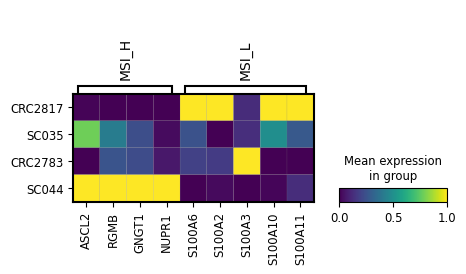

In [637]:
sc.pl.matrixplot(adata_epi_joanito_tumor, var_names={'MSI_H' : ['ASCL2', 'RGMB', 'GNGT1', 'NUPR1',], 'MSI_L':['S100A6', 'S100A2', 'S100A3', 'S100A10', 'S100A11']}, 
                 groupby='PatientID', 
                 categories_order=joanito_patient_order_by_MSI_intensity, standard_scale='var')

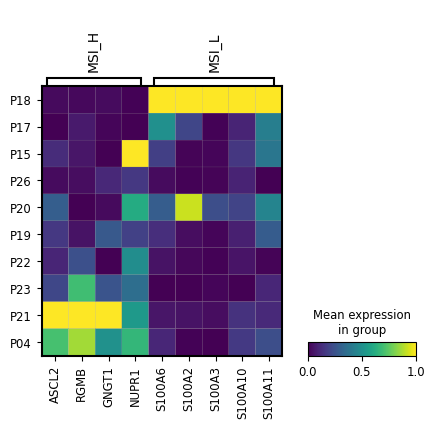

In [643]:
sc.pl.matrixplot(adata_epi_chen, var_names={'MSI_H' : ['ASCL2', 'RGMB', 'GNGT1', 'NUPR1',], 'MSI_L':['S100A6', 'S100A2', 'S100A3', 'S100A10', 'S100A11']}, 
                 groupby='PatientID', 
                 categories_order=chen_patient_order_by_MSI_intensity, standard_scale='var')

In [659]:
sc.pl.dotplot(adata_epi_joanito_tumor, var_names={'GD' : ['CD74', 'CD68'], 'MSI_H' : ['ASCL2', 'RGMB', 'GNGT1', 'NUPR1',], 'MSI_L':['S100A5', 'S100A6', 'S100A2', 'S100A3', 'S100A10', 'S100A11']}, 
                 groupby='MSI_class', 
                 # standard_scale='var'
                 )

In [658]:
sc.pl.dotplot(adata_epi_chen_tumor, var_names={'GD' : ['CD74', 'CD68'], 'MSI_H' : ['ASCL2', 'RGMB', 'GNGT1', 'NUPR1',], 'MSI_L':['S100A5', 'S100A6', 'S100A2', 'S100A3', 'S100A10', 'S100A11']}, 
                 groupby='MSI_class', 
                 # standard_scale='var', 
                 )

In [ ]:
adata_epi_chen_tumor.X[0]

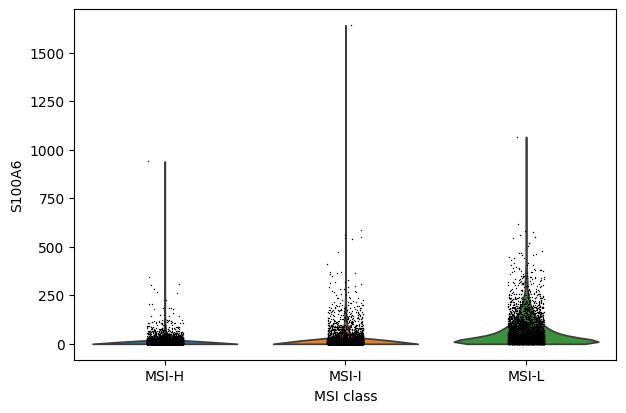

In [641]:
sc.pl.violin(adata_epi_chen_tumor, keys=['S100A6'], groupby='MSI_class')